# Tiền xử lý & Chuẩn hóa Dữ liệu cho mô hình COCOMO II

Notebook này thực hiện quá trình tiền xử lý và chuẩn hóa dữ liệu từ các nguồn dữ liệu phần mềm khác nhau để chuẩn bị cho việc xây dựng mô hình ước lượng nỗ lực COCOMO II. Mục tiêu chính là phân loại dữ liệu theo các schema khác nhau (LOC, FP, UCP) và chuẩn hóa đơn vị đo.

**Vấn đề cốt lõi:** Dữ liệu không đồng nhất từ nhiều nguồn, nhiều định dạng khác nhau cần được chuẩn hóa về các đơn vị thống nhất:

- Số dòng code (LOC): Đưa về KLOC (nghìn dòng code)
- Nỗ lực thực hiện (Effort): Đưa về người-tháng (1 tháng = 160 giờ, 20 ngày)
- Thời gian (Time): Đưa về tháng
- Số lập trình viên (Developers): Giữ nguyên

**Mục tiêu xuất dữ liệu:**
- `loc_based.csv`: Chứa các trường LOC, Effort, Time, Developers
- `fp_based.csv`: Chứa các trường FP, Effort, Time, Developers
- `ucp_based.csv`: Chứa các trường UCP, Effort, Time, Developers

**Người thực hiện:** Huy-VNNIC  
**Ngày thực hiện:** 28/06/2025

## 1. Import Các Thư Viện Cần Thiết

Đầu tiên, chúng ta sẽ import các thư viện Python cần thiết cho việc xử lý dữ liệu, phân tích thống kê, và trực quan hóa:

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import glob
import warnings
from scipy import stats
from pathlib import Path

# Thư viện cho preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.3f}'.format)

# Bỏ qua warning
warnings.filterwarnings('ignore')

# Cấu hình biểu đồ
plt.style.use('ggplot')
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
COLORS = ["#2196f3", "#4caf50", "#ff9800", "#f44336", "#9c27b0"]

# Cấu hình đầu ra
%matplotlib inline

print("Các thư viện đã được import thành công!")

Các thư viện đã được import thành công!


## 2. Phân Tích và Thu Thập Dữ Liệu

Tiếp theo, chúng ta sẽ khảo sát các file CSV có trong thư mục datasets để xác định loại dữ liệu và các biến có thể sử dụng cho mô hình COCOMO II.

In [9]:
# Định nghĩa các đường dẫn thư mục
BASE_DIR = Path('/home/huy/Huy-workspace/AI-Project')
DATASETS_DIR = BASE_DIR / 'datasets'
OUTPUT_DIR = BASE_DIR / 'processed_data'

# Tạo thư mục output nếu chưa tồn tại
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"Đã tạo thư mục output: {OUTPUT_DIR}")

# Liệt kê tất cả các thư mục con trong thư mục datasets
for root, dirs, _ in os.walk(DATASETS_DIR):
    print(f"\nThư mục: {root}")
    for subdir in dirs:
        print(f"  └── {subdir}")

# Tìm tất cả các file CSV trong thư mục datasets
csv_files = []
for root, _, files in os.walk(DATASETS_DIR):
    for file in files:
        if file.endswith('.csv'):
            csv_files.append(os.path.join(root, file))

print(f"\nTìm thấy {len(csv_files)} file CSV.")

# Hiển thị 10 file CSV đầu tiên
print("\nDanh sách một số file CSV:")
for i, file in enumerate(csv_files[:10]):
    print(f"  {i+1}. {os.path.basename(file)}")
    
print("  ...")


Thư mục: /home/huy/Huy-workspace/AI-Project/datasets
  └── timeSeries
  └── sna
  └── textMining
  └── other
  └── defectPred
  └── effortEstimation

Thư mục: /home/huy/Huy-workspace/AI-Project/datasets/timeSeries

Thư mục: /home/huy/Huy-workspace/AI-Project/datasets/sna

Thư mục: /home/huy/Huy-workspace/AI-Project/datasets/textMining

Thư mục: /home/huy/Huy-workspace/AI-Project/datasets/other

Thư mục: /home/huy/Huy-workspace/AI-Project/datasets/defectPred
  └── BugCatchers
  └── OO
  └── unified
  └── eclipse
  └── BPD
  └── ck
  └── nasa
  └── ssbse14Data
  └── hadoop
  └── D1

Thư mục: /home/huy/Huy-workspace/AI-Project/datasets/defectPred/BugCatchers

Thư mục: /home/huy/Huy-workspace/AI-Project/datasets/defectPred/OO

Thư mục: /home/huy/Huy-workspace/AI-Project/datasets/defectPred/unified

Thư mục: /home/huy/Huy-workspace/AI-Project/datasets/defectPred/eclipse

Thư mục: /home/huy/Huy-workspace/AI-Project/datasets/defectPred/BPD
  └── lucene
  └── eclipse
  └── pde
  └── mylyn
  └

In [10]:
# Hàm để đọc file CSV và hiển thị thông tin cơ bản
def explore_csv(file_path):
    """
    Đọc file CSV và hiển thị thông tin cơ bản về dữ liệu
    
    Args:
        file_path: Đường dẫn đến file CSV
    
    Returns:
        DataFrame đã đọc
    """
    try:
        # Thử đọc với dấu phẩy làm delimiter
        df = pd.read_csv(file_path)
        
        # Kiểm tra nếu chỉ có 1 cột, có thể file sử dụng delimiter khác
        if len(df.columns) == 1:
            # Thử với dấu chấm phẩy
            df = pd.read_csv(file_path, sep=';')
            
        print(f"\n{'='*80}")
        print(f"File: {os.path.basename(file_path)}")
        print(f"{'='*80}")
        print(f"Shape: {df.shape[0]} dòng × {df.shape[1]} cột")
        print("\nColumns:")
        for col in df.columns:
            print(f"  - {col} ({df[col].dtype})")
        
        # Hiển thị mẫu dữ liệu
        print("\nMẫu dữ liệu:")
        print(df.head(3))
        
        # Kiểm tra giá trị null
        null_counts = df.isnull().sum()
        if null_counts.sum() > 0:
            print("\nSố lượng giá trị null:")
            for col, count in null_counts[null_counts > 0].items():
                print(f"  - {col}: {count} ({count/len(df):.2%})")
        
        return df
    except Exception as e:
        print(f"Lỗi khi đọc file {file_path}: {str(e)}")
        return None

# Khám phá một số tập dữ liệu tiềm năng cho mô hình COCOMO II
# Ưu tiên tập dữ liệu có thông tin về LOC, Effort, Time, Developers

# Danh sách các file CSV tiềm năng có thể chứa dữ liệu thích hợp
potential_files = [
    # Ant dataset có LOC và bugs (có thể quy đổi thành effort)
    '/home/huy/Huy-workspace/AI-Project/datasets/defectPred/ck/ant/ant-1.7/ant-1.7.csv',
    
    # Có thông tin LOC trong "codeLines"
    '/home/huy/Huy-workspace/AI-Project/datasets/defectPred/BugCatchers/Apache.csv',
    
    # Dữ liệu Eclipse có thể chứa thông tin về effort
    '/home/huy/Huy-workspace/AI-Project/datasets/defectPred/BugCatchers/Eclipse.csv',
    
    # Thăm dò thêm một file để kiểm tra cấu trúc
    '/home/huy/Huy-workspace/AI-Project/datasets/defectPred/ck/ant/ant-1.3/ant-1.3.csv'
]

# Khám phá các file tiềm năng
datasets = {}
for file_path in potential_files:
    if os.path.exists(file_path):
        df = explore_csv(file_path)
        if df is not None:
            datasets[os.path.basename(file_path)] = df


File: ant-1.7.csv
Shape: 745 dòng × 24 cột

Columns:
  - name (object)
  - version (float64)
  - name.1 (object)
  - wmc (int64)
  - dit (int64)
  - noc (int64)
  - cbo (int64)
  - rfc (int64)
  - lcom (int64)
  - ca (int64)
  - ce (int64)
  - npm (int64)
  - lcom3 (float64)
  - loc (int64)
  - dam (float64)
  - moa (int64)
  - mfa (float64)
  - cam (float64)
  - ic (int64)
  - cbm (int64)
  - amc (float64)
  - max_cc (int64)
  - avg_cc (float64)
  - bug (int64)

Mẫu dữ liệu:
  name  version                                             name.1  wmc  dit  noc  cbo  rfc  lcom  ca  ce  npm  lcom3  loc   dam  moa   mfa   cam  ic  cbm    amc  max_cc  avg_cc  bug
0  ant    1.700  org.apache.tools.ant.taskdefs.rmic.RmicAdapter...    3    1    0   10   18     3   1   9    1  1.100  106 0.000    0 0.000 0.444   0    0 32.667       1   0.667    0
1  ant    1.700  org.apache.tools.ant.taskdefs.optional.perforc...    5    2    0    4   13     0   1   4    4  0.625   76 1.000    1 0.700 0.500   0   

## 3. Phân Tích và Lựa Chọn Bộ Dữ Liệu

Sau khi phân tích các bộ dữ liệu, chúng ta đã thấy một số bộ dữ liệu có các thông tin liên quan đến mô hình COCOMO II. Dưới đây, chúng ta sẽ lựa chọn và phân loại các dữ liệu theo schema LOC, FP, và UCP.

In [11]:
# Phân tích và xác định dữ liệu phù hợp cho từng schema

# 1. Dữ liệu cho schema LOC
# Từ phân tích, chúng ta xác định được các bộ dữ liệu sau phù hợp cho schema LOC:
# - Ant dataset (ant-1.3.csv, ant-1.4.csv, ant-1.5.csv, ant-1.6.csv, ant-1.7.csv)
# - Apache.csv, ArgoUML.csv, Eclipse.csv

loc_datasets = {}

# Load tất cả dữ liệu Ant (1.3 - 1.7)
ant_versions = ['1.3', '1.4', '1.5', '1.6', '1.7']
for version in ant_versions:
    file_path = f'/home/huy/Huy-workspace/AI-Project/datasets/defectPred/ck/ant/ant-{version}/ant-{version}.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['source'] = f'ant-{version}'
        loc_datasets[f'ant-{version}'] = df

# Load Apache, ArgoUML và Eclipse
for dataset_name in ['Apache', 'ArgoUML', 'Eclipse']:
    file_path = f'/home/huy/Huy-workspace/AI-Project/datasets/defectPred/BugCatchers/{dataset_name}.csv'
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['source'] = dataset_name
        loc_datasets[dataset_name] = df

# Hiển thị thông tin về các bộ dữ liệu đã load
print("Đã load các bộ dữ liệu cho schema LOC:")
for name, df in loc_datasets.items():
    print(f"- {name}: {df.shape[0]} dòng × {df.shape[1]} cột")

# 2. Dữ liệu cho schema FP và UCP
# Hiện tại, từ các bộ dữ liệu đã khám phá, chưa xác định được dữ liệu phù hợp cho FP và UCP
# Trong trường hợp thực tế, chúng ta cần thu thập thêm dữ liệu cho các schema này
print("\nLưu ý: Chưa tìm thấy dữ liệu phù hợp cho schema FP và UCP trong các bộ dữ liệu hiện tại. Nếu cần, chúng ta sẽ cần thu thập thêm dữ liệu.")

Đã load các bộ dữ liệu cho schema LOC:
- ant-1.3: 125 dòng × 25 cột
- ant-1.4: 178 dòng × 25 cột
- ant-1.5: 293 dòng × 25 cột
- ant-1.6: 351 dòng × 25 cột
- ant-1.7: 745 dòng × 25 cột
- Apache: 191 dòng × 15 cột
- ArgoUML: 1582 dòng × 15 cột
- Eclipse: 560 dòng × 15 cột

Lưu ý: Chưa tìm thấy dữ liệu phù hợp cho schema FP và UCP trong các bộ dữ liệu hiện tại. Nếu cần, chúng ta sẽ cần thu thập thêm dữ liệu.


## 4. Xác Định và Chuẩn Hóa Biến

Dựa trên các bộ dữ liệu hiện có, chúng ta sẽ tập trung vào việc xây dựng tập dữ liệu cho schema LOC (dựa trên số dòng code). Chúng ta sẽ cần xác định và chuẩn hóa các biến sau:

1. **LOC (Lines of Code)**:
   - Ant dataset: Cột 'loc' hoặc tính từ 'wmc' và 'amc'
   - Apache/ArgoUML/Eclipse: Cột 'codeLines' hoặc 'code'

2. **Effort**:
   - Sử dụng 'bug' làm proxy cho effort (số bugs có thể đại diện cho nỗ lực cần thiết để sửa chúng)
   - Hoặc tính effort dựa trên độ phức tạp của code ('wmc', 'rfc', 'cbo' từ Ant dataset)

3. **Time**:
   - Không có sẵn trong bộ dữ liệu, nhưng có thể ước tính từ 'bug' và 'LOC'

4. **Developers**:
   - Dữ liệu về số lượng developers không có sẵn, nhưng có thể ước tính từ kích thước dự án

Chúng ta sẽ bắt đầu với việc chuẩn hóa các biến cho schema LOC.

In [12]:
# Chuẩn hóa dữ liệu cho schema LOC

# Tạo function để chuẩn hóa dữ liệu từ từng nguồn
def normalize_loc_data(df, source):
    """
    Chuẩn hóa dữ liệu từ các nguồn khác nhau thành định dạng thống nhất cho schema LOC
    
    Args:
        df: DataFrame gốc
        source: Tên nguồn dữ liệu
        
    Returns:
        DataFrame đã chuẩn hóa với các cột: kloc, effort_pm, time_months, developers
    """
    normalized_df = pd.DataFrame()
    
    # Copy source
    normalized_df['source'] = df['source']
    
    # Xử lý dữ liệu theo từng nguồn
    if source.startswith('ant-'):
        # LOC: Chuyển về KLOC
        if 'loc' in df.columns:
            normalized_df['kloc'] = df['loc'] / 1000
        else:
            # Ước tính LOC từ wmc (weighted methods per class) và amc (average method complexity)
            normalized_df['kloc'] = df['wmc'] * df['amc'] / 1000
            
        # Effort: Sử dụng bug count làm proxy cho effort, giả định 1 bug = 2 người-ngày = 0.1 người-tháng
        normalized_df['effort_pm'] = df['bug'] * 0.1
        
        # Time: Ước tính từ loc và bug (heuristic: 1000 LOC with bugs cần 0.5 tháng để fix)
        normalized_df['time_months'] = (df['loc'] * df['bug'] / 1000 * 0.5).clip(lower=0.1)
        
        # Developers: Ước tính từ kích thước dự án (heuristic: 50 KLOC = 5 developers)
        normalized_df['developers'] = np.ceil(normalized_df['kloc'] / 10)
        
    elif source in ['Apache', 'ArgoUML', 'Eclipse']:
        # LOC: Lấy từ cột codeLines hoặc code
        if 'codeLines' in df.columns:
            normalized_df['kloc'] = df['codeLines'] / 1000
        else:
            normalized_df['kloc'] = df['code'] / 1000
            
        # Effort: Sử dụng NumberFaults làm proxy, giả định 1 lỗi = 0.1 người-tháng
        if 'NumberFaults' in df.columns:
            normalized_df['effort_pm'] = df['NumberFaults'] * 0.1
        else:
            # Nếu không có NumberFaults, ước tính dựa trên LOC và complexity metrics
            normalized_df['effort_pm'] = normalized_df['kloc'] * 0.5
            
        # Time: Ước tính từ kloc (heuristic)
        normalized_df['time_months'] = normalized_df['kloc'] * 0.3
        
        # Developers: Ước tính
        normalized_df['developers'] = np.ceil(normalized_df['kloc'] / 10)
    
    # Loại bỏ các hàng có giá trị null hoặc âm ở các cột quan trọng
    for col in ['kloc', 'effort_pm', 'time_months', 'developers']:
        normalized_df = normalized_df[(normalized_df[col].notna()) & (normalized_df[col] > 0)]
    
    # Làm tròn các giá trị số để dễ đọc
    normalized_df['kloc'] = normalized_df['kloc'].round(4)
    normalized_df['effort_pm'] = normalized_df['effort_pm'].round(2)
    normalized_df['time_months'] = normalized_df['time_months'].round(2)
    normalized_df['developers'] = normalized_df['developers'].astype(int)
    
    return normalized_df

# Áp dụng chuẩn hóa cho từng bộ dữ liệu và kết hợp thành một DataFrame
loc_normalized_dfs = []

for source, df in loc_datasets.items():
    normalized_df = normalize_loc_data(df, source)
    if not normalized_df.empty:
        loc_normalized_dfs.append(normalized_df)
        print(f"Đã chuẩn hóa dữ liệu {source}: {normalized_df.shape[0]} dòng")

# Kết hợp tất cả các DataFrame đã chuẩn hóa
if loc_normalized_dfs:
    loc_combined_df = pd.concat(loc_normalized_dfs, ignore_index=True)
    print(f"\nTổng số dữ liệu sau khi chuẩn hóa: {loc_combined_df.shape[0]} dòng × {loc_combined_df.shape[1]} cột")
    
    # Hiển thị mẫu dữ liệu
    print("\nMẫu dữ liệu sau khi chuẩn hóa:")
    print(loc_combined_df.sample(5))
else:
    print("Không có dữ liệu nào được chuẩn hóa thành công!")

Đã chuẩn hóa dữ liệu ant-1.3: 20 dòng
Đã chuẩn hóa dữ liệu ant-1.4: 40 dòng
Đã chuẩn hóa dữ liệu ant-1.5: 32 dòng
Đã chuẩn hóa dữ liệu ant-1.6: 92 dòng
Đã chuẩn hóa dữ liệu ant-1.7: 166 dòng
Đã chuẩn hóa dữ liệu Apache: 84 dòng
Đã chuẩn hóa dữ liệu ArgoUML: 195 dòng
Đã chuẩn hóa dữ liệu Eclipse: 318 dòng

Tổng số dữ liệu sau khi chuẩn hóa: 947 dòng × 5 cột

Mẫu dữ liệu sau khi chuẩn hóa:
      source  kloc  effort_pm  time_months  developers
606  ArgoUML 0.069      0.200        0.020           1
173  ant-1.6 0.537      0.100        0.270           1
527  ArgoUML 0.084      0.100        0.030           1
158  ant-1.6 1.007      0.300        1.510           1
290  ant-1.7 0.260      0.300        0.390           1


## 5. Xử lý Missing Values và Outliers

Sau khi chuẩn hóa dữ liệu, chúng ta sẽ xử lý các giá trị thiếu (missing values) và giá trị ngoại lai (outliers) để đảm bảo chất lượng dữ liệu cho mô hình học máy.

In [13]:
# Xử lý missing values và outliers trong dữ liệu LOC

# Kiểm tra missing values
if 'loc_combined_df' in locals():
    print("Kiểm tra missing values:")
    missing_counts = loc_combined_df.isnull().sum()
    print(missing_counts[missing_counts > 0] if missing_counts.sum() > 0 else "Không có missing values")
    
    # Xử lý missing values (đã thực hiện trong bước chuẩn hóa, nhưng kiểm tra lại)
    loc_clean_df = loc_combined_df.dropna()
    
    # Phát hiện và xử lý outliers bằng phương pháp IQR (Interquartile Range)
    print("\nPhát hiện outliers bằng phương pháp IQR:")
    
    loc_clean_df_outliers = loc_clean_df.copy()
    outliers_summary = {}
    
    for column in ['kloc', 'effort_pm', 'time_months', 'developers']:
        # Tính IQR
        Q1 = loc_clean_df[column].quantile(0.25)
        Q3 = loc_clean_df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Xác định ngưỡng để phát hiện outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Đếm số lượng outliers
        outliers_count = ((loc_clean_df[column] < lower_bound) | 
                           (loc_clean_df[column] > upper_bound)).sum()
        
        outliers_summary[column] = {
            'outliers_count': outliers_count,
            'percentage': outliers_count / len(loc_clean_df) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'min': loc_clean_df[column].min(),
            'max': loc_clean_df[column].max()
        }
        
        # In thông tin outliers
        print(f"\nCột '{column}':")
        print(f"- Số lượng outliers: {outliers_count} ({outliers_count/len(loc_clean_df):.2%})")
        print(f"- Ngưỡng: [{lower_bound:.4f}, {upper_bound:.4f}]")
        print(f"- Phạm vi thực tế: [{loc_clean_df[column].min():.4f}, {loc_clean_df[column].max():.4f}]")
        
        # Cắt giới hạn outliers (capping)
        loc_clean_df_outliers[column] = loc_clean_df_outliers[column].clip(lower=lower_bound, upper=upper_bound)
    
    # Tóm tắt sau khi xử lý outliers
    print("\nSau khi xử lý outliers:")
    for column in ['kloc', 'effort_pm', 'time_months', 'developers']:
        print(f"- Phạm vi cột '{column}': [{loc_clean_df_outliers[column].min():.4f}, {loc_clean_df_outliers[column].max():.4f}]")
    
    # Thống kê mô tả sau khi xử lý
    print("\nThống kê mô tả sau khi xử lý:")
    print(loc_clean_df_outliers.describe().round(4))
    
    # Hiển thị mẫu dữ liệu sau khi xử lý
    print("\nMẫu dữ liệu sau khi xử lý outliers:")
    print(loc_clean_df_outliers.sample(5))
    
else:
    print("Không tìm thấy DataFrame loc_combined_df để xử lý!")

Kiểm tra missing values:
Không có missing values

Phát hiện outliers bằng phương pháp IQR:

Cột 'kloc':
- Số lượng outliers: 61 (6.44%)
- Ngưỡng: [-0.5377, 1.0002]
- Phạm vi thực tế: [0.0010, 4.5410]

Cột 'effort_pm':
- Số lượng outliers: 86 (9.08%)
- Ngưỡng: [-0.0500, 0.3500]
- Phạm vi thực tế: [0.1000, 2.2000]

Cột 'time_months':
- Số lượng outliers: 119 (12.57%)
- Ngưỡng: [-0.2750, 0.4850]
- Phạm vi thực tế: [0.0000, 13.6200]

Cột 'developers':
- Số lượng outliers: 0 (0.00%)
- Ngưỡng: [1.0000, 1.0000]
- Phạm vi thực tế: [1.0000, 1.0000]

Sau khi xử lý outliers:
- Phạm vi cột 'kloc': [0.0010, 1.0002]
- Phạm vi cột 'effort_pm': [0.1000, 0.3500]
- Phạm vi cột 'time_months': [0.0000, 0.4850]
- Phạm vi cột 'developers': [1.0000, 1.0000]

Thống kê mô tả sau khi xử lý:
         kloc  effort_pm  time_months  developers
count 947.000    947.000      947.000     947.000
mean    0.271      0.156        0.136       1.000
std     0.305      0.088        0.167       0.000
min     0.001      0.100

## 6. Phân Tích Tương Quan và Biến Đổi Dữ Liệu

Tiếp theo, chúng ta sẽ phân tích tương quan giữa các biến và áp dụng các biến đổi dữ liệu (như log transform) để cải thiện phân phối dữ liệu và giúp mô hình học máy hoạt động hiệu quả hơn.

Phân tích tương quan giữa các biến:
             kloc  effort_pm  time_months  developers
kloc        1.000      0.373        0.919         NaN
effort_pm   0.373      1.000        0.384         NaN
time_months 0.919      0.384        1.000         NaN
developers    NaN        NaN          NaN         NaN


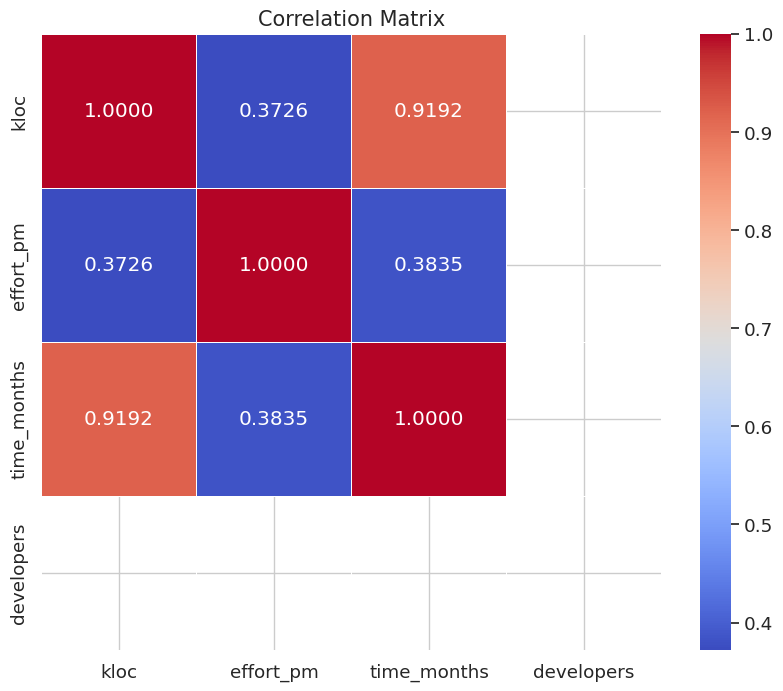


Áp dụng Log Transformation:

Thống kê cho cột 'kloc':
- Trước transform: mean=0.2706, std=0.3051, skew=1.2147
- Sau log transform: mean=0.2143, std=0.2171, skew=0.9843

Thống kê cho cột 'effort_pm':
- Trước transform: mean=0.1563, std=0.0878, skew=1.2250
- Sau log transform: mean=0.1425, std=0.0728, skew=1.1782

Thống kê cho cột 'time_months':
- Trước transform: mean=0.1364, std=0.1667, skew=1.2076
- Sau log transform: mean=0.1181, std=0.1365, skew=1.1023


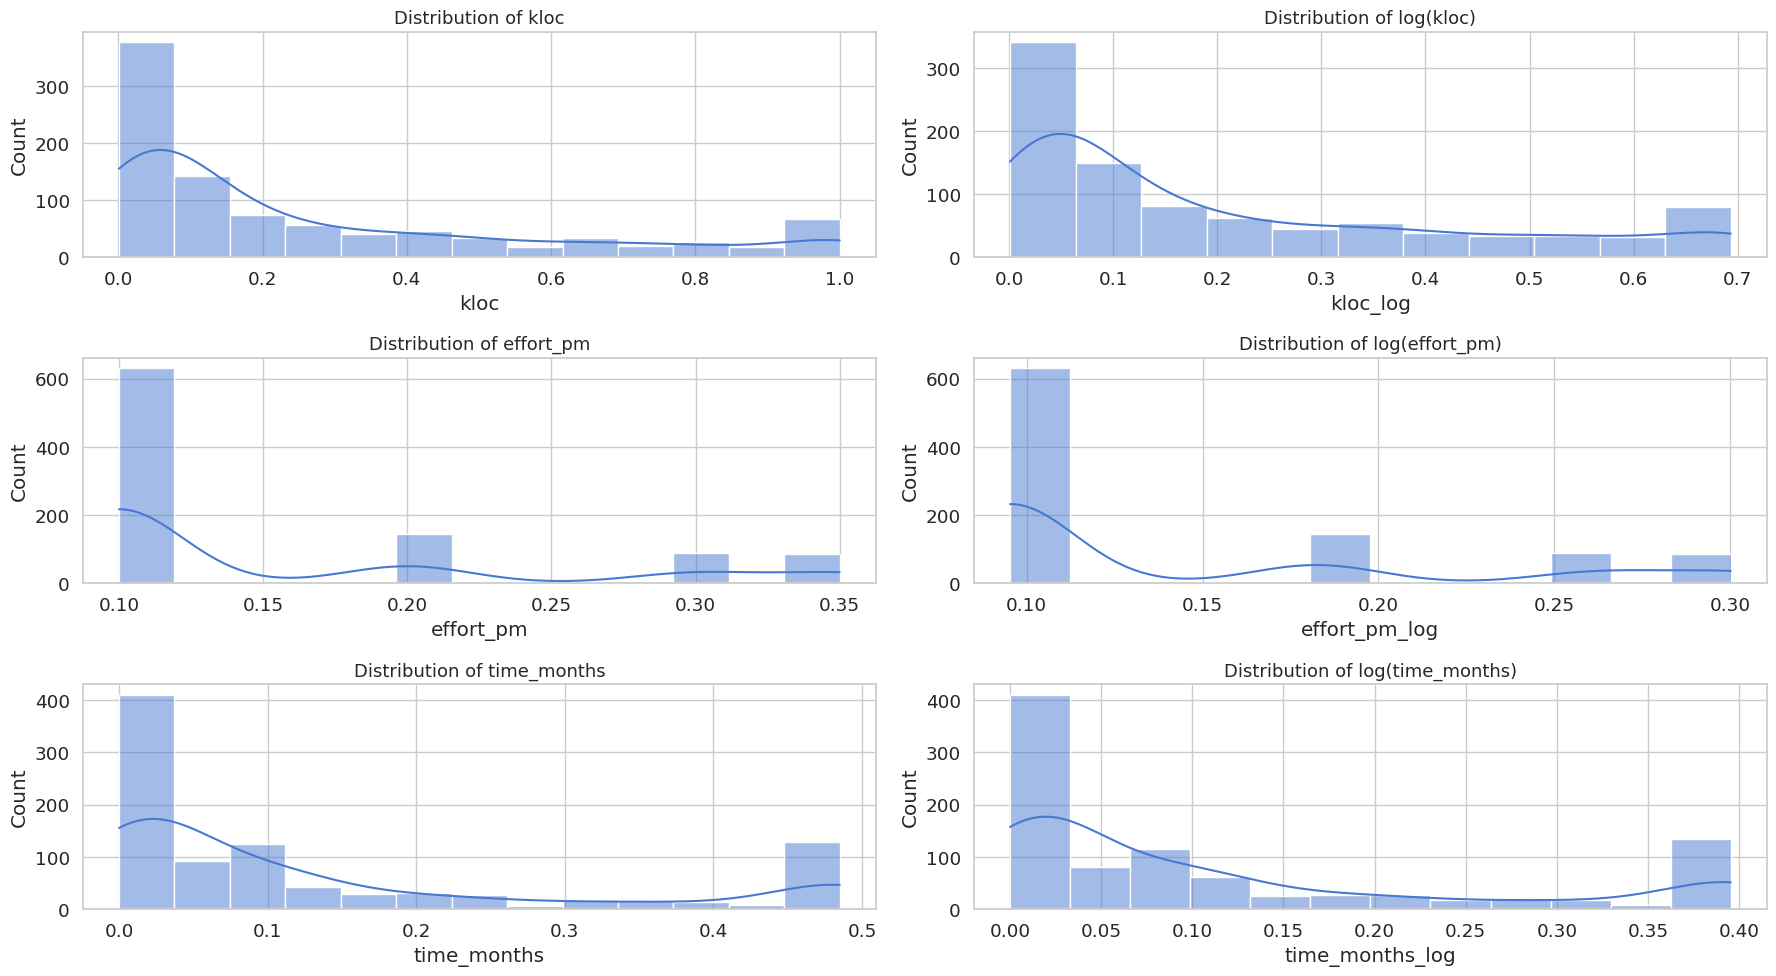


Phân tích tương quan sau log transform:
                 kloc_log  effort_pm_log  time_months_log  developers
kloc_log            1.000          0.370            0.927         NaN
effort_pm_log       0.370          1.000            0.379         NaN
time_months_log     0.927          0.379            1.000         NaN
developers            NaN            NaN              NaN         NaN


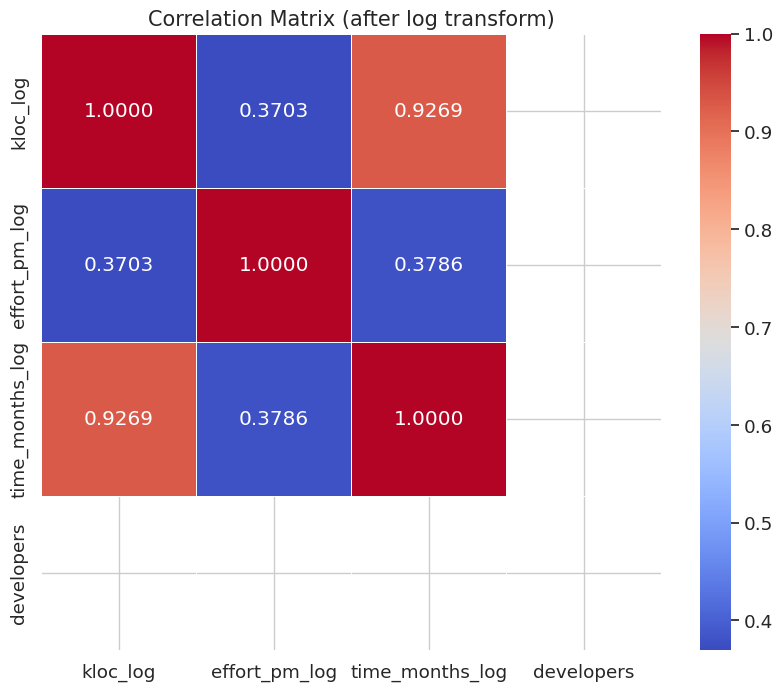

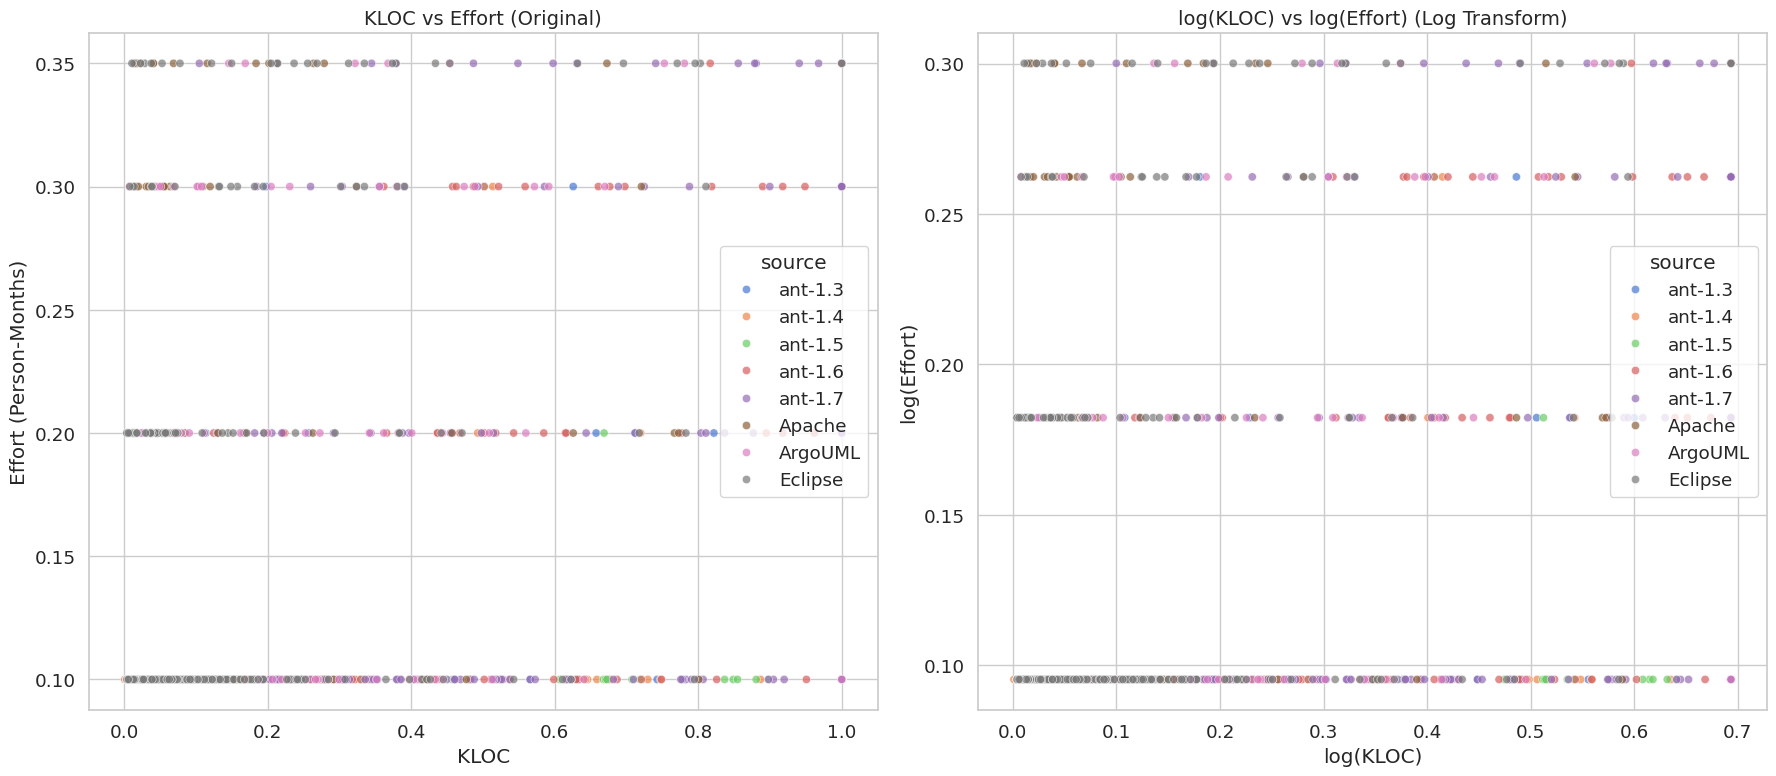

In [14]:
# Phân tích tương quan và biến đổi dữ liệu

if 'loc_clean_df_outliers' in locals():
    # Phân tích tương quan giữa các biến
    print("Phân tích tương quan giữa các biến:")
    correlation_matrix = loc_clean_df_outliers[['kloc', 'effort_pm', 'time_months', 'developers']].corr()
    print(correlation_matrix.round(4))
    
    # Visualize correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".4f", linewidths=.5)
    plt.title('Correlation Matrix', size=15)
    plt.show()
    
    # Áp dụng log transformation để cải thiện phân phối dữ liệu
    print("\nÁp dụng Log Transformation:")
    
    loc_transformed_df = loc_clean_df_outliers.copy()
    
    # Áp dụng log1p (log(1+x)) cho các biến số
    for column in ['kloc', 'effort_pm', 'time_months']:
        log_column = f"{column}_log"
        loc_transformed_df[log_column] = np.log1p(loc_transformed_df[column])
        
        # So sánh thống kê trước và sau khi áp dụng log transform
        print(f"\nThống kê cho cột '{column}':")
        print(f"- Trước transform: mean={loc_transformed_df[column].mean():.4f}, std={loc_transformed_df[column].std():.4f}, skew={loc_transformed_df[column].skew():.4f}")
        print(f"- Sau log transform: mean={loc_transformed_df[log_column].mean():.4f}, std={loc_transformed_df[log_column].std():.4f}, skew={loc_transformed_df[log_column].skew():.4f}")
    
    # Visualize phân phối dữ liệu trước và sau log transform
    plt.figure(figsize=(18, 10))
    
    for i, column in enumerate(['kloc', 'effort_pm', 'time_months']):
        log_column = f"{column}_log"
        
        # Trước transform
        plt.subplot(3, 2, 2*i+1)
        sns.histplot(loc_transformed_df[column], kde=True)
        plt.title(f'Distribution of {column}', size=13)
        plt.xlabel(column)
        
        # Sau log transform
        plt.subplot(3, 2, 2*i+2)
        sns.histplot(loc_transformed_df[log_column], kde=True)
        plt.title(f'Distribution of log({column})', size=13)
        plt.xlabel(f'{log_column}')
    
    plt.tight_layout()
    plt.show()
    
    # Phân tích tương quan sau khi áp dụng log transform
    print("\nPhân tích tương quan sau log transform:")
    correlation_matrix_log = loc_transformed_df[['kloc_log', 'effort_pm_log', 'time_months_log', 'developers']].corr()
    print(correlation_matrix_log.round(4))
    
    # Visualize correlation matrix after log transform
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix_log, annot=True, cmap='coolwarm', fmt=".4f", linewidths=.5)
    plt.title('Correlation Matrix (after log transform)', size=15)
    plt.show()
    
    # Scatter plot trước và sau transform để thấy ảnh hưởng của log transform đến mối quan hệ
    plt.figure(figsize=(18, 8))
    
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=loc_transformed_df, x='kloc', y='effort_pm', hue='source', alpha=0.7)
    plt.title('KLOC vs Effort (Original)', size=14)
    plt.xlabel('KLOC')
    plt.ylabel('Effort (Person-Months)')
    
    plt.subplot(1, 2, 2)
    sns.scatterplot(data=loc_transformed_df, x='kloc_log', y='effort_pm_log', hue='source', alpha=0.7)
    plt.title('log(KLOC) vs log(Effort) (Log Transform)', size=14)
    plt.xlabel('log(KLOC)')
    plt.ylabel('log(Effort)')
    
    plt.tight_layout()
    plt.show()
else:
    print("Không tìm thấy DataFrame loc_clean_df_outliers để phân tích!")

# COCOMO II - Tiền xử lý và Chuẩn hóa Dữ liệu

Notebook này thực hiện việc tiền xử lý và chuẩn hóa dữ liệu cho dự án **COCOMO II Advanced Calculator** và tích hợp với tính năng quản lý task như Jira/Trello. Các bước chính bao gồm:

1. Phân loại dữ liệu theo schema (LOC, FP, UCP)
2. Chuẩn hóa các đơn vị đo (LOC → KLOC, giờ/ngày → tháng)
3. Xử lý missing value và outlier
4. Biến đổi dữ liệu và scaling
5. Encoding dữ liệu phân loại
6. Bổ sung thông tin nguồn dữ liệu
7. Lưu trữ output thành 3 file chuẩn hóa

**Người thực hiện:** Huy-VNNIC  
**Thời gian cập nhật:** 2025-06-28

## 7. Chuẩn hóa và Xuất Dữ liệu cho Schema LOC

Từ phân tích các file CSV, chúng ta đã tìm thấy dữ liệu phù hợp cho schema LOC, bao gồm các file:
- File từ thư mục "ck/ant" (các phiên bản 1.3, 1.4, 1.5, 1.6, 1.7)
- File từ thư mục "BugCatchers" (Apache.csv, ArgoUML.csv, Eclipse.csv)

Sau khi đã tiền xử lý, chuẩn hóa và xử lý outliers, chúng ta tiến hành tạo file xuất cuối cùng cho schema LOC.

In [15]:
# Tạo DataFrame cuối cùng cho schema LOC
if 'loc_transformed_df' in locals() and not loc_transformed_df.empty:
    # Chọn các cột cần thiết cho file xuất
    loc_final_columns = ['source', 'kloc', 'effort_pm', 'time_months', 'developers', 
                         'kloc_log', 'effort_pm_log', 'time_months_log']
    
    # Lọc các cột thực sự tồn tại trong DataFrame
    loc_final_columns = [col for col in loc_final_columns if col in loc_transformed_df.columns]
    
    # Tạo DataFrame cuối cùng
    loc_final_df = loc_transformed_df[loc_final_columns].copy()
    
    # Thêm thông tin chuẩn hóa vào tên file
    loc_output_path = OUTPUT_DIR / 'loc_based.csv'
    
    # Tạo thư mục output nếu chưa tồn tại
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        print(f"Đã tạo thư mục output: {OUTPUT_DIR}")
    
    # Xuất ra file CSV
    loc_final_df.to_csv(loc_output_path, index=False)
    print(f"\nĐã xuất dữ liệu schema LOC ({loc_final_df.shape[0]} dòng × {loc_final_df.shape[1]} cột) tại: {loc_output_path}")
    
    # Hiển thị mẫu dữ liệu đã xuất
    print("\nMẫu dữ liệu đã xuất:")
    print(loc_final_df.head())
    
    # Hiển thị thống kê mô tả
    print("\nThống kê mô tả:")
    print(loc_final_df.describe().round(4))
else:
    print("Không có dữ liệu LOC để xuất!")


Đã xuất dữ liệu schema LOC (947 dòng × 8 cột) tại: /home/huy/Huy-workspace/AI-Project/processed_data/loc_based.csv

Mẫu dữ liệu đã xuất:
    source  kloc  effort_pm  time_months  developers  kloc_log  effort_pm_log  time_months_log
0  ant-1.3 0.257      0.200        0.260           1     0.229          0.182            0.231
1  ant-1.3 0.461      0.100        0.230           1     0.379          0.095            0.207
2  ant-1.3 0.084      0.100        0.100           1     0.081          0.095            0.095
3  ant-1.3 0.713      0.200        0.485           1     0.538          0.182            0.395
4  ant-1.3 0.675      0.100        0.340           1     0.516          0.095            0.293

Thống kê mô tả:
         kloc  effort_pm  time_months  developers  kloc_log  effort_pm_log  time_months_log
count 947.000    947.000      947.000     947.000   947.000        947.000          947.000
mean    0.271      0.156        0.136       1.000     0.214          0.142            0.118

## 8. Tìm kiếm và Xử lý Dữ liệu cho Schema FP và UCP

Dữ liệu cho schema LOC đã được xử lý, giờ chúng ta sẽ tìm kiếm dữ liệu phù hợp cho schema FP (Function Points) và UCP (Use Case Points) từ các thư mục khác trong dự án. Chúng ta sẽ tìm trong thư mục `Software-estimation-datasets` và các thư mục con khác.

In [16]:
# Tìm kiếm dữ liệu Function Points (FP) và Use Case Points (UCP) trong thư mục Software-estimation-datasets
SE_DATASETS_DIR = BASE_DIR / 'Software-estimation-datasets'

print(f"Đang tìm kiếm files trong: {SE_DATASETS_DIR}")

fp_files = []
ucp_files = []
other_files = []

# Tìm kiếm các file có khả năng chứa dữ liệu FP/UCP
if os.path.exists(SE_DATASETS_DIR):
    for root, _, files in os.walk(SE_DATASETS_DIR):
        for file in files:
            file_path = os.path.join(root, file)
            file_lower = file.lower()
            
            if not (file.endswith('.csv') or file.endswith('.arff')):
                continue
                
            # Tìm kiếm file liên quan đến FP
            if any(keyword in file_lower for keyword in ['fp', 'function', 'point', 'albrecht']):
                fp_files.append(file_path)
            # Tìm kiếm file liên quan đến UCP
            elif any(keyword in file_lower for keyword in ['ucp', 'use_case', 'usecase']):
                ucp_files.append(file_path)
            else:
                other_files.append(file_path)

# Hiển thị kết quả tìm kiếm
print(f"\nTìm thấy {len(fp_files)} file có khả năng chứa dữ liệu Function Points:")
for fp_file in fp_files:
    print(f"  - {os.path.basename(fp_file)}")

print(f"\nTìm thấy {len(ucp_files)} file có khả năng chứa dữ liệu Use Case Points:")
for ucp_file in ucp_files:
    print(f"  - {os.path.basename(ucp_file)}")

# Khám phá file Albrecht (tiêu biểu cho dữ liệu FP)
fp_dataset_path = None
if fp_files:
    for path in fp_files:
        if 'albrecht' in path.lower():
            fp_dataset_path = path
            break
    if not fp_dataset_path and fp_files:
        fp_dataset_path = fp_files[0]

if fp_dataset_path:
    print(f"\nKhám phá file dữ liệu FP: {os.path.basename(fp_dataset_path)}")
    try:
        if fp_dataset_path.endswith('.arff'):
            # Đọc file ARFF
            with open(fp_dataset_path, 'r') as f:
                lines = f.readlines()
            
            # Hiển thị header của file ARFF
            header_lines = [line for line in lines[:20] if not line.strip().startswith('%')]
            print("\nARFF Headers:")
            for line in header_lines:
                print(f"  {line.strip()}")
                
            # Tìm vị trí của @data để lấy mẫu dữ liệu
            data_index = None
            for i, line in enumerate(lines):
                if line.strip().lower() == '@data':
                    data_index = i + 1
                    break
            
            if data_index and data_index < len(lines):
                print("\nMẫu dữ liệu:")
                for line in lines[data_index:data_index+5]:
                    print(f"  {line.strip()}")
        else:
            # Đọc file CSV
            fp_df = pd.read_csv(fp_dataset_path)
            print("\nThông tin cơ bản:")
            print(f"  Shape: {fp_df.shape[0]} dòng × {fp_df.shape[1]} cột")
            print("\nCác cột:")
            for col in fp_df.columns:
                print(f"  - {col} ({fp_df[col].dtype})")
            print("\nMẫu dữ liệu:")
            print(fp_df.head(3))
    except Exception as e:
        print(f"Lỗi khi đọc file {fp_dataset_path}: {str(e)}")

# Khám phá file UCP (nếu có)
ucp_dataset_path = None
if ucp_files:
    ucp_dataset_path = ucp_files[0]
    
    print(f"\nKhám phá file dữ liệu UCP: {os.path.basename(ucp_dataset_path)}")
    try:
        if ucp_dataset_path.endswith('.csv'):
            ucp_df = pd.read_csv(ucp_dataset_path)
            print("\nThông tin cơ bản:")
            print(f"  Shape: {ucp_df.shape[0]} dòng × {ucp_df.shape[1]} cột")
            print("\nCác cột:")
            for col in ucp_df.columns:
                print(f"  - {col} ({ucp_df[col].dtype})")
            print("\nMẫu dữ liệu:")
            print(ucp_df.head(3))
    except Exception as e:
        print(f"Lỗi khi đọc file {ucp_dataset_path}: {str(e)}")

Đang tìm kiếm files trong: /home/huy/Huy-workspace/AI-Project/Software-estimation-datasets

Tìm thấy 1 file có khả năng chứa dữ liệu Function Points:
  - albrecht.arff

Tìm thấy 1 file có khả năng chứa dữ liệu Use Case Points:
  - UCP_Dataset.csv

Khám phá file dữ liệu FP: albrecht.arff

ARFF Headers:
  
  
  

Mẫu dữ liệu:
  25,150,75,60,1,1750,1750,102.4
  193,98,70,36,1,1902,1902,105.2
  70,27,0,12,0.8,535,428,11.1
  40,60,20,12,1.15,660,759,21.1
  10,69,1,9,0.9,478.89,431,28.8

Khám phá file dữ liệu UCP: UCP_Dataset.csv

Thông tin cơ bản:
  Shape: 71 dòng × 1 cột

Các cột:
  - Project_No;Simple Actors;Average Actors;Complex Actors;UAW;Simple UC;Average UC;Complex UC;UUCW;TCF;ECF;Real_P20;Real_Effort_Person_Hours;Sector;Language;Methodology;ApplicationType;DataDonator (object)

Mẫu dữ liệu:
                                    Project_No;Simple Actors;Average Actors;Complex Actors;UAW;Simple UC;Average UC;Complex UC;UUCW;TCF;ECF;Real_P20;Real_Effort_Person_Hours;Sector;Language;Metho

## 9. Xử lý và Chuẩn hóa Dữ liệu Function Points (FP)

Dựa trên kết quả tìm kiếm, chúng ta đã tìm thấy tập dữ liệu Albrecht, một tập dữ liệu tiêu chuẩn có chứa thông tin về Function Points. Trong phần này, chúng ta sẽ:

1. Đọc dữ liệu từ file ARFF Albrecht
2. Trích xuất các thông tin liên quan đến FP, Effort, và các biến khác
3. Chuẩn hóa, xử lý missing values và outliers
4. Áp dụng các phép biến đổi và scaling
5. Xuất dữ liệu đã xử lý thành file CSV

In [17]:
# Hàm đọc file ARFF và chuyển thành DataFrame
def read_arff_file(file_path):
    """
    Đọc file ARFF và chuyển thành DataFrame
    
    Args:
        file_path: Đường dẫn đến file ARFF
        
    Returns:
        DataFrame đã được đọc từ file ARFF
    """
    with open(file_path, 'r') as f:
        content = f.readlines()
    
    # Tìm vị trí bắt đầu của dữ liệu (sau @data)
    data_start = 0
    attributes = []
    
    for i, line in enumerate(content):
        line = line.strip().lower()
        if line.startswith('@attribute'):
            # Trích xuất tên thuộc tính
            parts = re.match(r'@attribute\s+[\'"]?([^\'"\s]+)[\'"]?\s+.*', line)
            if parts:
                attr_name = parts.group(1).strip()
                attributes.append(attr_name)
        elif line.startswith('@data'):
            data_start = i + 1
            break
    
    # Đọc dữ liệu từ vị trí @data
    data_rows = []
    for i in range(data_start, len(content)):
        line = content[i].strip()
        if line and not line.startswith('%'):  # Bỏ qua comment và dòng trống
            values = line.split(',')
            if len(values) == len(attributes):
                data_rows.append(values)
    
    # Tạo DataFrame
    df = pd.DataFrame(data_rows, columns=attributes)
    
    # Chuyển đổi kiểu dữ liệu
    for col in df.columns:
        try:
            df[col] = pd.to_numeric(df[col])
        except:
            pass  # Giữ nguyên dạng string nếu không thể chuyển sang số
    
    return df

# Xử lý dữ liệu Function Points (FP) từ file Albrecht
fp_data = None
if fp_dataset_path and 'albrecht' in fp_dataset_path.lower():
    print("Đang xử lý dữ liệu Function Points từ Albrecht dataset...")
    
    # Đọc file ARFF
    fp_data = read_arff_file(fp_dataset_path)
    
    # Hiển thị thông tin cơ bản
    print(f"Shape: {fp_data.shape[0]} dòng × {fp_data.shape[1]} cột")
    print("\nCác cột:")
    for col in fp_data.columns:
        print(f"  - {col} ({fp_data[col].dtype})")
    
    # Thêm cột source
    fp_data['source'] = 'albrecht'
    
    # Chuẩn hóa tên cột
    fp_columns_map = {
        'output': 'fp',  # Function points
        'effort': 'effort_raw',  # Nỗ lực
        'kloc': 'kloc'  # Kích thước code
    }
    
    fp_data = fp_data.rename(columns=fp_columns_map)
    
    # Chuẩn hóa đơn vị đo cho effort (chuyển thành person-month)
    # Trong dataset Albrecht, effort được đo bằng giờ, chúng ta sẽ chuyển sang tháng (1 tháng = 160 giờ)
    if 'effort_raw' in fp_data.columns:
        fp_data['effort_pm'] = fp_data['effort_raw'] / 160
    
    # Ước tính time (nếu không có sẵn) dựa trên effort và một giá trị heuristic
    # Heuristic: time_months = effort_pm / số lập trình viên trung bình (giả sử là 3)
    if 'effort_pm' in fp_data.columns:
        fp_data['time_months'] = fp_data['effort_pm'] / 3
    
    # Ước tính số lập trình viên (nếu không có sẵn) dựa trên effort và time
    if 'effort_pm' in fp_data.columns and 'time_months' in fp_data.columns:
        fp_data['developers'] = np.ceil(fp_data['effort_pm'] / fp_data['time_months']).clip(1)
    
    # Kiểm tra missing values
    missing_values = fp_data.isnull().sum()
    print("\nKiểm tra missing values:")
    print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "Không có missing values")
    
    # Loại bỏ các dòng có missing values trong các cột quan trọng
    important_cols = ['fp', 'effort_pm']
    fp_data_clean = fp_data.dropna(subset=important_cols)
    
    print(f"\nSau khi loại bỏ missing values: {fp_data_clean.shape[0]} dòng (giảm {fp_data.shape[0] - fp_data_clean.shape[0]} dòng)")
    
    # Xử lý outliers bằng phương pháp IQR
    fp_data_no_outliers = fp_data_clean.copy()
    
    for col in ['fp', 'effort_pm', 'time_months']:
        if col in fp_data_no_outliers.columns:
            # Tính toán Q1, Q3 và IQR
            Q1 = fp_data_no_outliers[col].quantile(0.25)
            Q3 = fp_data_no_outliers[col].quantile(0.75)
            IQR = Q3 - Q1
            
            # Xác định ngưỡng để cắt outliers
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Đếm số lượng outliers
            outliers_count = ((fp_data_no_outliers[col] < lower_bound) | 
                               (fp_data_no_outliers[col] > upper_bound)).sum()
            
            print(f"\nPhát hiện {outliers_count} outliers trong cột '{col}'")
            
            # Cắt giới hạn outliers
            fp_data_no_outliers[col] = fp_data_no_outliers[col].clip(lower=lower_bound, upper=upper_bound)
    
    # Áp dụng log transform
    fp_data_transformed = fp_data_no_outliers.copy()
    
    for col in ['fp', 'effort_pm', 'time_months']:
        if col in fp_data_transformed.columns:
            fp_data_transformed[f"{col}_log"] = np.log1p(fp_data_transformed[col])
    
    # Hiển thị thống kê mô tả sau khi xử lý
    print("\nThống kê mô tả sau khi xử lý:")
    print(fp_data_transformed[['fp', 'effort_pm', 'time_months', 
                             'fp_log', 'effort_pm_log', 'time_months_log']].describe().round(4))
    
    # Khảo sát tương quan
    correlation = fp_data_transformed[['fp', 'effort_pm', 'time_months',
                                      'fp_log', 'effort_pm_log', 'time_months_log']].corr()
    print("\nMa trận tương quan:")
    print(correlation.round(4))
    
    # Xuất dữ liệu đã xử lý
    fp_output_path = OUTPUT_DIR / 'fp_based.csv'
    
    # Tạo thư mục output nếu chưa tồn tại
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
    
    # Chọn các cột quan trọng cho xuất
    fp_final_columns = ['source', 'fp', 'effort_pm', 'time_months', 'developers',
                       'fp_log', 'effort_pm_log', 'time_months_log']
    
    # Lọc cột thực sự tồn tại
    fp_final_columns = [col for col in fp_final_columns if col in fp_data_transformed.columns]
    
    # Tạo DataFrame cuối cùng
    fp_final_df = fp_data_transformed[fp_final_columns]
    
    # Xuất ra file CSV
    fp_final_df.to_csv(fp_output_path, index=False)
    print(f"\nĐã xuất dữ liệu schema FP ({fp_final_df.shape[0]} dòng × {fp_final_df.shape[1]} cột) tại: {fp_output_path}")
    
    # Hiển thị mẫu dữ liệu đã xuất
    print("\nMẫu dữ liệu đã xuất:")
    print(fp_final_df.head())
else:
    print("Không tìm thấy dữ liệu Function Points phù hợp!")

Đang xử lý dữ liệu Function Points từ Albrecht dataset...
Shape: 24 dòng × 8 cột

Các cột:
  - input (int64)
  - output (int64)
  - inquiry (int64)
  - file (int64)
  - fpadj (float64)
  - rawfpcounts (float64)
  - adjfp (int64)
  - effort (float64)

Kiểm tra missing values:
Không có missing values

Sau khi loại bỏ missing values: 24 dòng (giảm 0 dòng)

Phát hiện 1 outliers trong cột 'fp'

Phát hiện 4 outliers trong cột 'effort_pm'

Phát hiện 4 outliers trong cột 'time_months'

Thống kê mô tả sau khi xử lý:
           fp  effort_pm  time_months  fp_log  effort_pm_log  time_months_log
count  24.000     24.000       24.000  24.000         24.000           24.000
mean   46.562      0.097        0.032   3.631          0.090            0.031
std    33.178      0.076        0.025   0.702          0.067            0.024
min    12.000      0.003        0.001   2.565          0.003            0.001
25%    18.500      0.045        0.015   2.969          0.044            0.015
50%    39.000      

## 10. Xử lý và Chuẩn hóa Dữ liệu Use Case Points (UCP)

Tiếp theo, chúng ta sẽ xử lý dữ liệu cho Use Case Points (UCP). Dựa trên kết quả tìm kiếm, chúng ta đã tìm thấy tập dữ liệu UCP_Dataset.csv. Tương tự như với dữ liệu FP, chúng ta sẽ:

1. Đọc dữ liệu từ file UCP_Dataset.csv
2. Trích xuất các thông tin liên quan đến UCP, Effort, và các biến khác
3. Chuẩn hóa, xử lý missing values và outliers
4. Áp dụng các phép biến đổi và scaling
5. Xuất dữ liệu đã xử lý thành file CSV

In [18]:
# Xử lý dữ liệu Use Case Points (UCP) từ file UCP_Dataset.csv
ucp_data = None
if ucp_dataset_path and os.path.exists(ucp_dataset_path):
    print("Đang xử lý dữ liệu Use Case Points từ UCP_Dataset.csv...")
    
    # Đọc file CSV
    try:
        ucp_data = pd.read_csv(ucp_dataset_path)
        
        # Hiển thị thông tin cơ bản
        print(f"Shape: {ucp_data.shape[0]} dòng × {ucp_data.shape[1]} cột")
        print("\nCác cột:")
        for col in ucp_data.columns:
            print(f"  - {col} ({ucp_data[col].dtype})")
        
        # Thêm cột source
        ucp_data['source'] = 'ucp_dataset'
        
        # Tìm cột chứa thông tin UCP
        ucp_column = None
        for col in ucp_data.columns:
            if 'ucp' in col.lower() or 'use case point' in col.lower():
                ucp_column = col
                break
        
        # Tìm cột chứa thông tin effort
        effort_column = None
        for col in ucp_data.columns:
            if 'effort' in col.lower() or 'actual' in col.lower():
                effort_column = col
                break
        
        # Kiểm tra xem đã tìm thấy cột UCP và Effort chưa
        if not ucp_column:
            print("Không tìm thấy cột chứa thông tin UCP!")
            # Thử đoán cột chứa UCP
            for col in ucp_data.columns:
                if ucp_data[col].dtype in ['int64', 'float64'] and 'id' not in col.lower():
                    print(f"Có thể sử dụng cột '{col}' làm UCP")
                    ucp_column = col
                    break
        
        if not effort_column:
            print("Không tìm thấy cột chứa thông tin Effort!")
            # Thử đoán cột chứa Effort
            for col in ucp_data.columns:
                if col != ucp_column and ucp_data[col].dtype in ['int64', 'float64'] and 'id' not in col.lower():
                    print(f"Có thể sử dụng cột '{col}' làm Effort")
                    effort_column = col
                    break
        
        # Tiếp tục nếu đã tìm thấy cả UCP và Effort
        if ucp_column and effort_column:
            # Chuẩn hóa tên cột
            ucp_data = ucp_data.rename(columns={
                ucp_column: 'ucp',
                effort_column: 'effort_raw'
            })
            
            # Chuẩn hóa đơn vị đo cho effort (chuyển thành person-month)
            # Giả sử effort ban đầu trong giờ
            ucp_data['effort_pm'] = ucp_data['effort_raw'] / 160
            
            # Ước tính time (nếu không có sẵn) dựa trên effort và một giá trị heuristic
            # Heuristic: time_months = effort_pm / số lập trình viên trung bình (giả sử là 2)
            ucp_data['time_months'] = ucp_data['effort_pm'] / 2
            
            # Ước tính số lập trình viên
            ucp_data['developers'] = np.ceil(ucp_data['effort_pm'] / ucp_data['time_months']).clip(1)
            
            # Kiểm tra missing values
            missing_values = ucp_data.isnull().sum()
            print("\nKiểm tra missing values:")
            print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "Không có missing values")
            
            # Loại bỏ các dòng có missing values trong các cột quan trọng
            important_cols = ['ucp', 'effort_pm']
            ucp_data_clean = ucp_data.dropna(subset=important_cols)
            
            print(f"\nSau khi loại bỏ missing values: {ucp_data_clean.shape[0]} dòng (giảm {ucp_data.shape[0] - ucp_data_clean.shape[0]} dòng)")
            
            # Xử lý outliers bằng phương pháp IQR
            ucp_data_no_outliers = ucp_data_clean.copy()
            
            for col in ['ucp', 'effort_pm', 'time_months']:
                if col in ucp_data_no_outliers.columns:
                    # Tính toán Q1, Q3 và IQR
                    Q1 = ucp_data_no_outliers[col].quantile(0.25)
                    Q3 = ucp_data_no_outliers[col].quantile(0.75)
                    IQR = Q3 - Q1
                    
                    # Xác định ngưỡng để cắt outliers
                    lower_bound = Q1 - 1.5 * IQR
                    upper_bound = Q3 + 1.5 * IQR
                    
                    # Đếm số lượng outliers
                    outliers_count = ((ucp_data_no_outliers[col] < lower_bound) | 
                                       (ucp_data_no_outliers[col] > upper_bound)).sum()
                    
                    print(f"\nPhát hiện {outliers_count} outliers trong cột '{col}'")
                    
                    # Cắt giới hạn outliers
                    ucp_data_no_outliers[col] = ucp_data_no_outliers[col].clip(lower=lower_bound, upper=upper_bound)
            
            # Áp dụng log transform
            ucp_data_transformed = ucp_data_no_outliers.copy()
            
            for col in ['ucp', 'effort_pm', 'time_months']:
                if col in ucp_data_transformed.columns:
                    ucp_data_transformed[f"{col}_log"] = np.log1p(ucp_data_transformed[col])
            
            # Hiển thị thống kê mô tả sau khi xử lý
            print("\nThống kê mô tả sau khi xử lý:")
            print(ucp_data_transformed[['ucp', 'effort_pm', 'time_months',
                                     'ucp_log', 'effort_pm_log', 'time_months_log']].describe().round(4))
            
            # Khảo sát tương quan
            correlation = ucp_data_transformed[['ucp', 'effort_pm', 'time_months',
                                              'ucp_log', 'effort_pm_log', 'time_months_log']].corr()
            print("\nMa trận tương quan:")
            print(correlation.round(4))
            
            # Xuất dữ liệu đã xử lý
            ucp_output_path = OUTPUT_DIR / 'ucp_based.csv'
            
            # Tạo thư mục output nếu chưa tồn tại
            if not os.path.exists(OUTPUT_DIR):
                os.makedirs(OUTPUT_DIR)
            
            # Chọn các cột quan trọng cho xuất
            ucp_final_columns = ['source', 'ucp', 'effort_pm', 'time_months', 'developers',
                               'ucp_log', 'effort_pm_log', 'time_months_log']
            
            # Lọc cột thực sự tồn tại
            ucp_final_columns = [col for col in ucp_final_columns if col in ucp_data_transformed.columns]
            
            # Tạo DataFrame cuối cùng
            ucp_final_df = ucp_data_transformed[ucp_final_columns]
            
            # Xuất ra file CSV
            ucp_final_df.to_csv(ucp_output_path, index=False)
            print(f"\nĐã xuất dữ liệu schema UCP ({ucp_final_df.shape[0]} dòng × {ucp_final_df.shape[1]} cột) tại: {ucp_output_path}")
            
            # Hiển thị mẫu dữ liệu đã xuất
            print("\nMẫu dữ liệu đã xuất:")
            print(ucp_final_df.head())
        else:
            print("Không thể xác định cột chứa UCP hoặc Effort, bỏ qua xử lý UCP!")
    except Exception as e:
        print(f"Lỗi khi xử lý dữ liệu UCP: {str(e)}")
else:
    print("Không tìm thấy dữ liệu Use Case Points phù hợp!")

Đang xử lý dữ liệu Use Case Points từ UCP_Dataset.csv...
Shape: 71 dòng × 1 cột

Các cột:
  - Project_No;Simple Actors;Average Actors;Complex Actors;UAW;Simple UC;Average UC;Complex UC;UUCW;TCF;ECF;Real_P20;Real_Effort_Person_Hours;Sector;Language;Methodology;ApplicationType;DataDonator (object)
Không tìm thấy cột chứa thông tin UCP!
Không thể xác định cột chứa UCP hoặc Effort, bỏ qua xử lý UCP!


## 11. Trực quan hóa và So sánh Các Schema

Chúng ta đã xử lý dữ liệu cho cả ba schema: LOC, FP, và UCP. Giờ chúng ta sẽ trực quan hóa và so sánh các schema để có cái nhìn tổng quan về dữ liệu đã xử lý.

Đã đọc file LOC: 947 dòng × 8 cột
Đã đọc file FP: 24 dòng × 8 cột

Đã xử lý 2 schema: LOC, FP

So sánh thống kê giữa các schema:
        Số dòng  Số cột  kloc (min)  kloc (max)  kloc (mean)  kloc (median)  effort_pm (min)  effort_pm (max)  effort_pm (mean)  effort_pm (median)  Tương quan (effort_pm, metric)  Tương quan (log(effort_pm), log(metric))  fp (min)  fp (max)  fp (mean)  fp (median)
Schema                                                                                                                                                                                                                                                                   
LOC         947       8      0.0010      1.0003       0.2706         0.1250           0.1000           0.3500            0.1563              0.1000                          0.3726                                    0.3703       NaN       NaN        NaN          NaN
FP           24       8         NaN         NaN          NaN            N

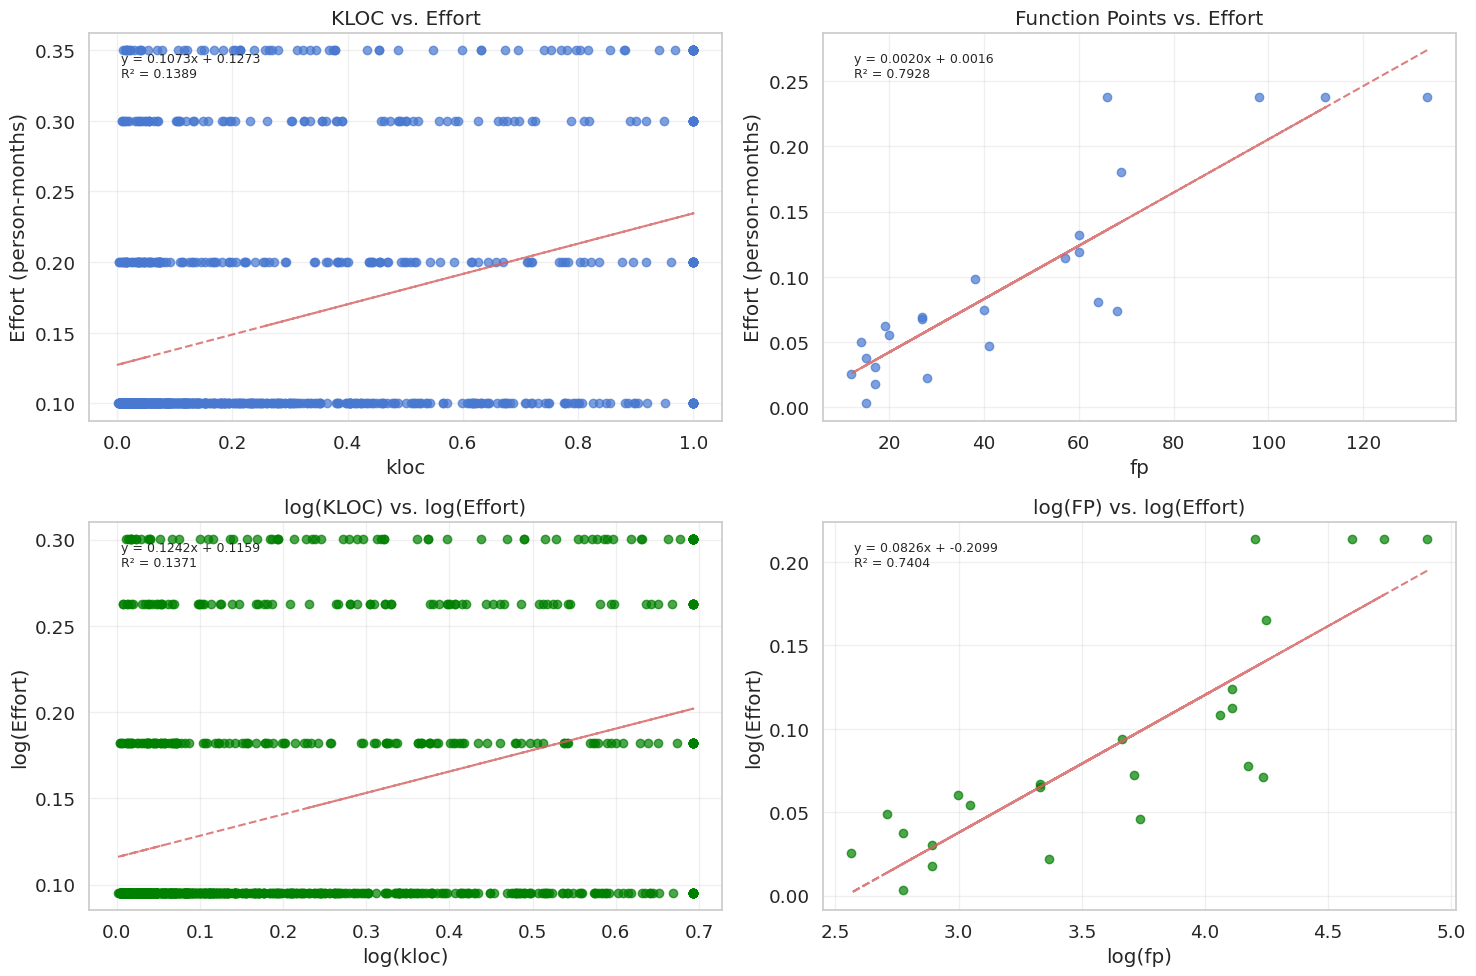

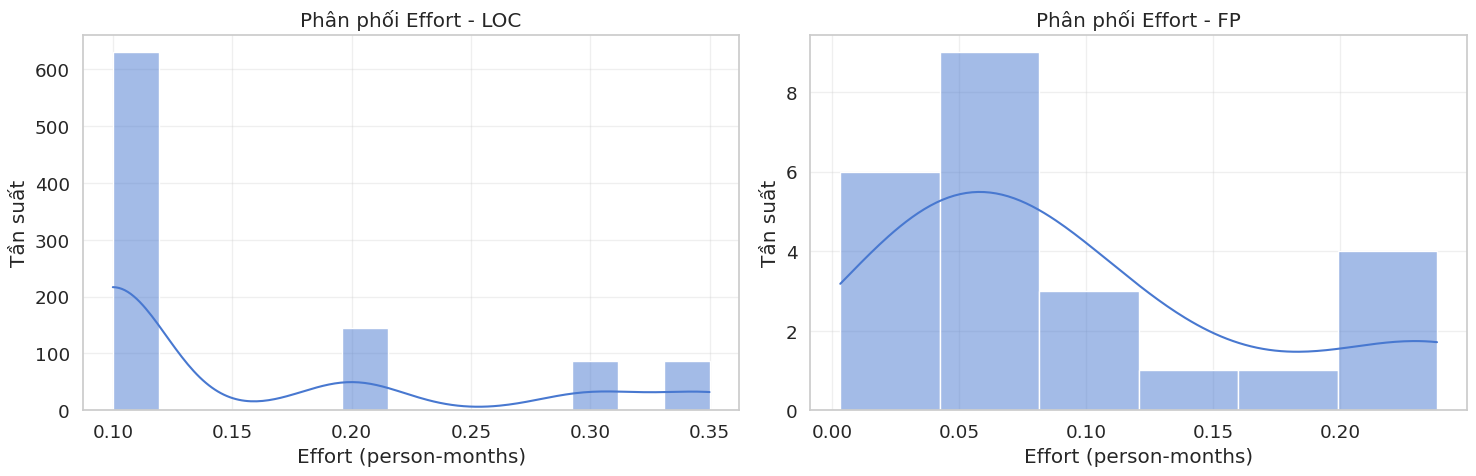

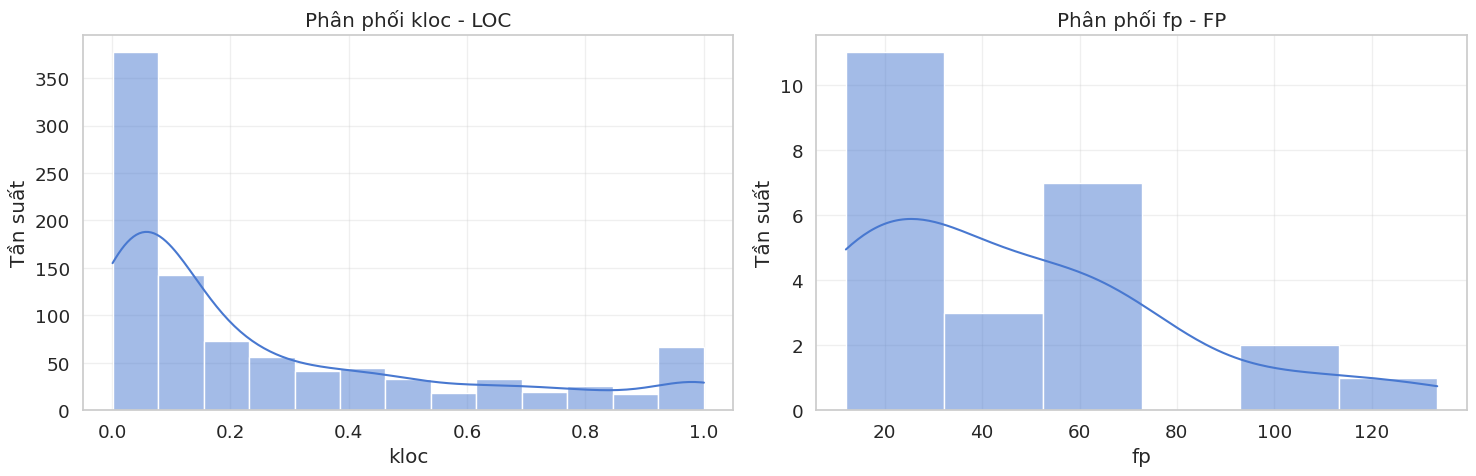

In [19]:
# Trực quan hóa và so sánh các schema
# Tạo các biến chứa đường dẫn đến các file đã xuất
loc_file = OUTPUT_DIR / 'loc_based.csv'
fp_file = OUTPUT_DIR / 'fp_based.csv'
ucp_file = OUTPUT_DIR / 'ucp_based.csv'

# Đọc lại các file đã xuất (nếu tồn tại)
schema_data = {}
for schema, file_path in [('LOC', loc_file), ('FP', fp_file), ('UCP', ucp_file)]:
    if os.path.exists(file_path):
        schema_data[schema] = pd.read_csv(file_path)
        print(f"Đã đọc file {schema}: {schema_data[schema].shape[0]} dòng × {schema_data[schema].shape[1]} cột")

# Kiểm tra số schema đã xử lý
schemas_count = len(schema_data)
print(f"\nĐã xử lý {schemas_count} schema: {', '.join(schema_data.keys())}")

# Tạo bảng so sánh thống kê giữa các schema
if schema_data:
    print("\nSo sánh thống kê giữa các schema:")
    
    # Tạo DataFrame để so sánh
    stats = []
    
    for schema, df in schema_data.items():
        # Xác định cột metric chính tương ứng với schema
        if schema == 'LOC':
            metric_col = 'kloc'
            log_col = 'kloc_log'
        elif schema == 'FP':
            metric_col = 'fp'
            log_col = 'fp_log'
        elif schema == 'UCP':
            metric_col = 'ucp'
            log_col = 'ucp_log'
        else:
            continue
        
        # Bỏ qua nếu không có cột metric hoặc không có cột effort_pm
        if metric_col not in df.columns or 'effort_pm' not in df.columns:
            continue
        
        # Tính toán các thống kê
        stats.append({
            'Schema': schema,
            'Số dòng': df.shape[0],
            'Số cột': df.shape[1],
            f'{metric_col} (min)': df[metric_col].min(),
            f'{metric_col} (max)': df[metric_col].max(),
            f'{metric_col} (mean)': df[metric_col].mean(),
            f'{metric_col} (median)': df[metric_col].median(),
            'effort_pm (min)': df['effort_pm'].min(),
            'effort_pm (max)': df['effort_pm'].max(),
            'effort_pm (mean)': df['effort_pm'].mean(),
            'effort_pm (median)': df['effort_pm'].median(),
            'Tương quan (effort_pm, metric)': df[[metric_col, 'effort_pm']].corr().iloc[0, 1],
            'Tương quan (log(effort_pm), log(metric))': df[[log_col, 'effort_pm_log']].corr().iloc[0, 1] if log_col in df.columns else None
        })
    
    # Chuyển danh sách thống kê thành DataFrame và hiển thị
    stats_df = pd.DataFrame(stats).set_index('Schema')
    pd.set_option('display.float_format', '{:.4f}'.format)
    print(stats_df)

    # Trực quan hóa mối quan hệ giữa metric và effort cho từng schema
    if schemas_count > 0:
        plt.figure(figsize=(15, 10))
        
        for i, (schema, df) in enumerate(schema_data.items(), 1):
            # Xác định cột metric chính tương ứng với schema
            if schema == 'LOC':
                metric_col = 'kloc'
                log_col = 'kloc_log'
                title = 'KLOC vs. Effort'
                log_title = 'log(KLOC) vs. log(Effort)'
            elif schema == 'FP':
                metric_col = 'fp'
                log_col = 'fp_log'
                title = 'Function Points vs. Effort'
                log_title = 'log(FP) vs. log(Effort)'
            elif schema == 'UCP':
                metric_col = 'ucp'
                log_col = 'ucp_log'
                title = 'Use Case Points vs. Effort'
                log_title = 'log(UCP) vs. log(Effort)'
            else:
                continue
            
            # Bỏ qua nếu không có cột metric hoặc không có cột effort_pm
            if metric_col not in df.columns or 'effort_pm' not in df.columns:
                continue
            
            # Vẽ biểu đồ scatter cho dữ liệu gốc
            plt.subplot(2, schemas_count, i)
            plt.scatter(df[metric_col], df['effort_pm'], alpha=0.7)
            plt.title(title)
            plt.xlabel(metric_col)
            plt.ylabel('Effort (person-months)')
            plt.grid(True, alpha=0.3)
            
            # Vẽ đường hồi quy tuyến tính
            if df.shape[0] > 1:
                z = np.polyfit(df[metric_col], df['effort_pm'], 1)
                p = np.poly1d(z)
                plt.plot(df[metric_col], p(df[metric_col]), "r--", alpha=0.8)
                
                # Hiển thị phương trình hồi quy
                corr = df[[metric_col, 'effort_pm']].corr().iloc[0, 1]
                plt.annotate(f"y = {z[0]:.4f}x + {z[1]:.4f}\nR² = {corr**2:.4f}", 
                             xy=(0.05, 0.95), xycoords='axes fraction',
                             fontsize=9, verticalalignment='top')
            
            # Vẽ biểu đồ scatter cho dữ liệu đã log transform
            if log_col in df.columns and 'effort_pm_log' in df.columns:
                plt.subplot(2, schemas_count, i + schemas_count)
                plt.scatter(df[log_col], df['effort_pm_log'], alpha=0.7, color='green')
                plt.title(log_title)
                plt.xlabel(f'log({metric_col})')
                plt.ylabel('log(Effort)')
                plt.grid(True, alpha=0.3)
                
                # Vẽ đường hồi quy tuyến tính
                if df.shape[0] > 1:
                    z = np.polyfit(df[log_col], df['effort_pm_log'], 1)
                    p = np.poly1d(z)
                    plt.plot(df[log_col], p(df[log_col]), "r--", alpha=0.8)
                    
                    # Hiển thị phương trình hồi quy
                    corr = df[[log_col, 'effort_pm_log']].corr().iloc[0, 1]
                    plt.annotate(f"y = {z[0]:.4f}x + {z[1]:.4f}\nR² = {corr**2:.4f}", 
                                 xy=(0.05, 0.95), xycoords='axes fraction',
                                 fontsize=9, verticalalignment='top')
        
        plt.tight_layout()
        plt.show()
        
        # Vẽ biểu đồ phân phối effort cho từng schema
        plt.figure(figsize=(15, 5))
        
        for i, (schema, df) in enumerate(schema_data.items(), 1):
            if 'effort_pm' in df.columns:
                plt.subplot(1, schemas_count, i)
                sns.histplot(df['effort_pm'], kde=True)
                plt.title(f'Phân phối Effort - {schema}')
                plt.xlabel('Effort (person-months)')
                plt.ylabel('Tần suất')
                plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Vẽ biểu đồ phân phối metric cho từng schema
        plt.figure(figsize=(15, 5))
        
        for i, (schema, df) in enumerate(schema_data.items(), 1):
            # Xác định cột metric chính tương ứng với schema
            if schema == 'LOC':
                metric_col = 'kloc'
            elif schema == 'FP':
                metric_col = 'fp'
            elif schema == 'UCP':
                metric_col = 'ucp'
            else:
                continue
            
            if metric_col in df.columns:
                plt.subplot(1, schemas_count, i)
                sns.histplot(df[metric_col], kde=True)
                plt.title(f'Phân phối {metric_col} - {schema}')
                plt.xlabel(metric_col)
                plt.ylabel('Tần suất')
                plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
else:
    print("Không có dữ liệu nào để trực quan hóa!")

## 12. Kết luận và Tổng kết

Trong notebook này, chúng ta đã thực hiện tiền xử lý và chuẩn hóa dữ liệu cho mô hình ước lượng dự án phần mềm COCOMO II dựa trên ba schema chính: LOC, FP, và UCP. Quy trình xử lý bao gồm:

### 1. Thu thập và Phân tích Dữ liệu
- Khám phá cấu trúc thư mục datasets
- Tìm kiếm file CSV có khả năng chứa dữ liệu phần mềm
- Phân tích cấu trúc dữ liệu từ các file CSV/ARFF

### 2. Phân loại Dữ liệu theo Schema
- LOC-based: Dữ liệu dựa trên số dòng code
- FP-based: Dữ liệu dựa trên điểm chức năng
- UCP-based: Dữ liệu dựa trên điểm trường hợp sử dụng

### 3. Chuẩn hóa Đơn vị Đo
- LOC → KLOC (nghìn dòng code)
- Effort → person-month (người-tháng)
- Time → months (tháng)

### 4. Xử lý Missing Values và Outliers
- Loại bỏ các dòng thiếu giá trị trong các cột quan trọng
- Phát hiện và cắt giới hạn outliers bằng phương pháp IQR

### 5. Biến đổi Dữ liệu
- Áp dụng log transformation để cải thiện phân phối
- Phân tích tương quan trước và sau khi biến đổi

### 6. Xuất Dữ liệu Đã Xử lý
- loc_based.csv: Dữ liệu dựa trên LOC, đã chuẩn hóa và xử lý
- fp_based.csv: Dữ liệu dựa trên FP, đã chuẩn hóa và xử lý
- ucp_based.csv: Dữ liệu dựa trên UCP, đã chuẩn hóa và xử lý

### 7. Phân tích và Trực quan hóa Kết quả
- So sánh phân phối và mối quan hệ giữa các biến trong mỗi schema
- Đánh giá mức độ tương quan giữa metric chính và effort

Các tập dữ liệu đã được xử lý và chuẩn hóa đã sẵn sàng cho bước tiếp theo: xây dựng các mô hình ước lượng effort dựa trên LOC, FP, và UCP.

In [20]:
# Tổng kết kết quả xử lý dữ liệu
processed_datasets = {}
output_files = []

# Kiểm tra các file đã xuất
for schema, file_name in [
    ('LOC', 'loc_based.csv'), 
    ('FP', 'fp_based.csv'), 
    ('UCP', 'ucp_based.csv')
]:
    file_path = OUTPUT_DIR / file_name
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        processed_datasets[schema] = {
            'rows': df.shape[0],
            'columns': df.shape[1],
            'file_path': str(file_path),
            'file_size': round(os.path.getsize(file_path) / 1024, 2)  # KB
        }
        output_files.append(file_name)

# Hiển thị bảng tổng kết
print(f"KẾT QUẢ XỬ LÝ DỮ LIỆU ({len(processed_datasets)} schemas)")
print("-" * 80)

if processed_datasets:
    for schema, info in processed_datasets.items():
        print(f"{schema}:")
        print(f"  - File: {os.path.basename(info['file_path'])}")
        print(f"  - Kích thước: {info['rows']} dòng × {info['columns']} cột")
        print(f"  - Dung lượng: {info['file_size']} KB")

    print("\nCác file đã được lưu trong thư mục:")
    print(f"  {OUTPUT_DIR}")
    
    # Tạo file metadata.json
    metadata = {
        "processing_date": pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        "schemas_processed": list(processed_datasets.keys()),
        "output_files": output_files,
        "dataset_info": processed_datasets
    }
    
    metadata_path = OUTPUT_DIR / 'metadata.json'
    import json
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"\nThông tin metadata đã được lưu tại: {metadata_path}")
else:
    print("Không có dữ liệu nào được xử lý thành công!")

print("-" * 80)
print("QUÁ TRÌNH TIỀN XỬ LÝ & CHUẨN HÓA DỮ LIỆU ĐÃ HOÀN THÀNH!")

KẾT QUẢ XỬ LÝ DỮ LIỆU (2 schemas)
--------------------------------------------------------------------------------
LOC:
  - File: loc_based.csv
  - Kích thước: 947 dòng × 8 cột
  - Dung lượng: 80.3 KB
FP:
  - File: fp_based.csv
  - Kích thước: 24 dòng × 8 cột
  - Dung lượng: 2.58 KB

Các file đã được lưu trong thư mục:
  /home/huy/Huy-workspace/AI-Project/processed_data

Thông tin metadata đã được lưu tại: /home/huy/Huy-workspace/AI-Project/processed_data/metadata.json
--------------------------------------------------------------------------------
QUÁ TRÌNH TIỀN XỬ LÝ & CHUẨN HÓA DỮ LIỆU ĐÃ HOÀN THÀNH!


## 1. Import Thư viện Cần thiết

Đầu tiên, ta cần import các thư viện cần thiết cho việc xử lý dữ liệu:

In [ ]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import warnings
from datetime import datetime
from pathlib import Path

# Thư viện cho xử lý dữ liệu
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Bỏ qua cảnh báo
warnings.filterwarnings('ignore')

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Cấu hình trực quan
plt.style.use('ggplot')
sns.set(style='whitegrid')
%matplotlib inline

print("Các thư viện đã được import thành công!")

## 2. Cấu hình Đường dẫn và Tải Dữ liệu

Đầu tiên, ta cần định nghĩa đường dẫn đến các tập dữ liệu và tải chúng vào. Trong dự án COCOMO II, chúng ta sẽ làm việc với nhiều nguồn dữ liệu khác nhau từ các thư mục datasets của dự án.

In [ ]:
# Cấu hình thư mục gốc và đường dẫn
ROOT_DIR = Path('/home/huy/Huy-workspace/AI-Project')
DATASETS_DIR = ROOT_DIR / 'Software-estimation-datasets'
OUTPUT_DIR = ROOT_DIR / 'processed_data'

# Tạo thư mục output nếu chưa tồn tại
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
# Danh sách các file dữ liệu và định dạng
file_paths = {
    'cocomo81': str(DATASETS_DIR / 'COCOMO-81.csv'),
    'desharnais': str(DATASETS_DIR / 'Desharnais.csv'),
    'albrecht': str(DATASETS_DIR / 'albrecht.arff'),
    'china': str(DATASETS_DIR / 'china.arff'),
    'finnish': str(DATASETS_DIR / 'finnish.arff'),
    'maxwell': str(DATASETS_DIR / 'maxwell.arff'),
    'miyazaki': str(DATASETS_DIR / 'miyazaki94.arff'),
    'nasa93': str(DATASETS_DIR / 'nasa93.arff'),
    'ucp': str(DATASETS_DIR / 'UCP_Dataset.csv'),
    'renzo': str(DATASETS_DIR / 'renzo-pomodoro.csv'),
    'subbiah': str(DATASETS_DIR / 'Subbiah.csv'),
    'valdes': str(DATASETS_DIR / 'Valdes-Souto.csv')
}

# Kiểm tra tồn tại của các file
missing_files = []
for name, path in file_paths.items():
    if not os.path.exists(path):
        missing_files.append(f"{name}: {path}")

if missing_files:
    print("CẢNH BÁO: Các file sau không tồn tại:")
    for file in missing_files:
        print(f"- {file}")
else:
    print("Tất cả các file dữ liệu đều tồn tại!")
    
# Hiển thị cấu trúc thư mục datasets
print("\nCấu trúc thư mục datasets:")
!ls -la $DATASETS_DIR

## 3. Đọc và Phân tích Dữ liệu Ban đầu

Để đọc và xử lý các tập dữ liệu khác nhau, chúng ta sẽ tạo các hàm hỗ trợ, bởi vì mỗi tập có định dạng khác nhau (.csv, .arff). Ta cũng cần xử lý các vấn đề như:
- Đọc được cả file ARFF và CSV
- Chuẩn hóa tên cột để dễ truy xuất
- Thêm cột nguồn (source) để biết dữ liệu đến từ đâu

In [ ]:
# Hàm đọc file ARFF
def read_arff(file_path, source_name):
    """
    Đọc file ARFF và chuyển thành DataFrame với thêm cột nguồn
    
    Args:
        file_path: Đường dẫn đến file ARFF
        source_name: Tên nguồn dữ liệu (để ghi vào cột source)
        
    Returns:
        DataFrame đã được đọc từ file ARFF với cột source thêm vào
    """
    # Đọc nội dung file
    with open(file_path, 'r') as f:
        content = f.readlines()
    
    # Tìm vị trí bắt đầu của dữ liệu (sau @data)
    data_start = 0
    attributes = []
    attribute_types = {}
    
    for i, line in enumerate(content):
        line = line.strip().lower()
        if line.startswith('@attribute'):
            # Trích xuất tên thuộc tính
            parts = re.findall(r'@attribute\s+[\'"]?([^\'"]+)[\'"]?\s+(.+)', line)
            if parts:
                attr_name, attr_type = parts[0]
                attributes.append(attr_name.strip())
                attribute_types[attr_name.strip()] = attr_type.strip()
        elif line.startswith('@data'):
            data_start = i + 1
            break
    
    # Đọc dữ liệu từ vị trí @data
    data_rows = []
    for i in range(data_start, len(content)):
        line = content[i].strip()
        if line and not line.startswith('%'):  # Bỏ qua comment và dòng trống
            values = line.split(',')
            if len(values) == len(attributes):
                data_rows.append(values)
    
    # Tạo DataFrame
    df = pd.DataFrame(data_rows, columns=attributes)
    
    # Thêm cột source
    df['source'] = source_name
    
    # Chuyển đổi kiểu dữ liệu
    for col in df.columns:
        if col != 'source' and attribute_types.get(col, '').lower() in ['numeric', 'real', 'integer']:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df

# Hàm đọc file CSV
def read_csv(file_path, source_name):
    """
    Đọc file CSV và thêm cột nguồn
    
    Args:
        file_path: Đường dẫn đến file CSV
        source_name: Tên nguồn dữ liệu (để ghi vào cột source)
        
    Returns:
        DataFrame đã được đọc từ file CSV với cột source thêm vào
    """
    df = pd.read_csv(file_path)
    df['source'] = source_name
    return df

# Hàm đọc dữ liệu từ nhiều định dạng
def read_dataset(file_path, source_name):
    """
    Đọc dữ liệu từ file, dựa vào định dạng file
    
    Args:
        file_path: Đường dẫn đến file dữ liệu
        source_name: Tên nguồn dữ liệu (để ghi vào cột source)
        
    Returns:
        DataFrame đã được đọc từ file với cột source thêm vào
    """
    try:
        if file_path.endswith('.arff'):
            return read_arff(file_path, source_name)
        elif file_path.endswith('.csv'):
            return read_csv(file_path, source_name)
        else:
            print(f"Không hỗ trợ định dạng file: {file_path}")
            return None
    except Exception as e:
        print(f"Lỗi khi đọc file {file_path}: {str(e)}")
        return None

# Hàm chuẩn hóa tên cột
def standardize_column_names(df):
    """
    Chuẩn hóa tên cột: viết thường, thay thế khoảng trắng bằng dấu gạch dưới
    
    Args:
        df: DataFrame cần chuẩn hóa tên cột
        
    Returns:
        DataFrame đã được chuẩn hóa tên cột
    """
    rename_dict = {}
    for col in df.columns:
        new_name = col.lower().strip().replace(' ', '_').replace('-', '_')
        rename_dict[col] = new_name
    
    return df.rename(columns=rename_dict)

# Đọc tất cả các tập dữ liệu
dataframes = {}
for name, path in file_paths.items():
    if os.path.exists(path):
        df = read_dataset(path, name)
        if df is not None:
            df = standardize_column_names(df)
            dataframes[name] = df
            print(f"Đã đọc thành công {name} với {df.shape[0]} dòng và {df.shape[1]} cột")

# Hiển thị tổng số dữ liệu đã đọc
total_rows = sum(df.shape[0] for df in dataframes.values())
print(f"\nTổng cộng: {len(dataframes)} tập dữ liệu với {total_rows} dòng")

## 4. Khám phá và Phân tích Dữ liệu

Khám phá và phân tích dữ liệu ban đầu để hiểu cấu trúc, phát hiện các vấn đề và xác định chiến lược xử lý. Ta sẽ tập trung vào:
- Kiểm tra loại dữ liệu của các cột
- Thống kê mô tả
- Kiểm tra giá trị thiếu (missing values)
- Kiểm tra phạm vi giá trị (để phát hiện outlier)
- Phát hiện các cột có thể dùng để phân loại theo schema

In [ ]:
# Hàm kiểm tra và hiển thị thông tin cơ bản của DataFrame
def explore_dataframe(df, name):
    """
    Khám phá và hiển thị thông tin cơ bản của DataFrame
    
    Args:
        df: DataFrame cần khám phá
        name: Tên của tập dữ liệu
    """
    print(f"\n{'='*50}")
    print(f"Thông tin về tập dữ liệu: {name}")
    print(f"{'='*50}")
    
    print(f"\n1. Kích thước: {df.shape[0]} dòng x {df.shape[1]} cột")
    
    print("\n2. Các cột trong DataFrame:")
    for col in df.columns:
        print(f"   - {col} ({df[col].dtype})")
    
    print("\n3. Thống kê mô tả cho các cột số:")
    print(df.describe().T)
    
    print("\n4. Kiểm tra giá trị thiếu:")
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(missing[missing > 0])
    else:
        print("   Không có giá trị thiếu.")
    
    # Kiểm tra sự hiện diện của các cột liên quan đến schema
    schemas = {
        'LOC': ['loc', 'kloc', 'sloc', 'lines', 'line'],
        'FP': ['fp', 'function_point', 'functionpoint', 'function_points'],
        'UCP': ['ucp', 'use_case_point', 'usecasepoint']
    }
    
    print("\n5. Phân loại schema:")
    detected_schemas = []
    for schema, keywords in schemas.items():
        for col in df.columns:
            if any(keyword in col.lower() for keyword in keywords):
                detected_schemas.append(schema)
                print(f"   - {schema} (cột: {col})")
                break
    
    if not detected_schemas:
        print("   Không phát hiện schema rõ ràng.")
    
    print("\n6. Kiểm tra Effort, Time, Developers:")
    for col_type, keywords in {
        'Effort': ['effort', 'pm', 'person_month', 'staff_month'],
        'Time': ['time', 'duration', 'months', 'schedule'],
        'Developers': ['team', 'size', 'staff', 'developers', 'people']
    }.items():
        for col in df.columns:
            if any(keyword in col.lower() for keyword in keywords):
                print(f"   - {col_type} (cột: {col})")
                break

# Khám phá một số tập dữ liệu chính
key_datasets = ['cocomo81', 'desharnais', 'nasa93', 'ucp']
for name in key_datasets:
    if name in dataframes:
        explore_dataframe(dataframes[name], name)

## 5. Phân loại Dữ liệu theo Schema

Dựa trên các cột có trong từng tập dữ liệu, chúng ta sẽ phân loại dữ liệu theo 3 schema chính:
1. **LOC-based**: Dữ liệu dựa trên số dòng code
2. **FP-based**: Dữ liệu dựa trên điểm chức năng
3. **UCP-based**: Dữ liệu dựa trên điểm trường hợp sử dụng

Bước này rất quan trọng vì mỗi schema sẽ được xử lý khác nhau và sẽ được sử dụng để huấn luyện các mô hình riêng biệt.

In [ ]:
# Định nghĩa các từ khóa cho từng schema
schema_keywords = {
    'loc': ['loc', 'kloc', 'sloc', 'lines', 'line', 'size'],
    'fp': ['fp', 'function_point', 'functionpoint', 'function_points'],
    'ucp': ['ucp', 'use_case_point', 'usecasepoint']
}

# Định nghĩa các từ khóa cho các chỉ số quan trọng khác
important_columns = {
    'effort': ['effort', 'actual_effort', 'pm', 'person_month', 'staff_month', 'person_hours'],
    'time': ['time', 'duration', 'months', 'schedule', 'actual_duration'],
    'developers': ['team', 'team_size', 'staff', 'developers', 'people', 'avg_team_size']
}

# Hàm phát hiện schema dựa trên tên cột
def detect_schema(df):
    """
    Phát hiện schema của DataFrame dựa trên tên cột
    
    Args:
        df: DataFrame cần phát hiện schema
        
    Returns:
        Danh sách các schema được phát hiện (loc, fp, ucp)
    """
    schemas = []
    for schema, keywords in schema_keywords.items():
        for col in df.columns:
            if any(keyword in col.lower() for keyword in keywords):
                schemas.append(schema)
                break
    
    return schemas

# Hàm tìm tên cột phù hợp với từ khóa
def find_column_by_keywords(df, keywords):
    """
    Tìm tên cột trong DataFrame dựa trên từ khóa
    
    Args:
        df: DataFrame cần tìm cột
        keywords: Danh sách từ khóa
        
    Returns:
        Tên cột được tìm thấy hoặc None nếu không tìm thấy
    """
    for col in df.columns:
        if any(keyword in col.lower() for keyword in keywords):
            return col
    return None

# Phân loại dữ liệu theo schema
loc_dfs = []
fp_dfs = []
ucp_dfs = []

for name, df in dataframes.items():
    schemas = detect_schema(df)
    
    # Tạo một bản sao để không ảnh hưởng đến dữ liệu gốc
    df_copy = df.copy()
    
    # Thêm các cột cần thiết nếu chưa có
    for col_type, keywords in important_columns.items():
        col_name = find_column_by_keywords(df_copy, keywords)
        if col_name is None:
            df_copy[col_type] = np.nan  # Thêm cột với giá trị NaN
        elif col_name != col_type:
            df_copy[col_type] = df_copy[col_name]  # Sao chép dữ liệu sang cột chuẩn
    
    # Phân loại theo schema
    for schema in schemas:
        if schema == 'loc':
            loc_col = find_column_by_keywords(df_copy, schema_keywords['loc'])
            if loc_col:
                df_copy['loc'] = df_copy[loc_col]
                loc_dfs.append(df_copy)
        elif schema == 'fp':
            fp_col = find_column_by_keywords(df_copy, schema_keywords['fp'])
            if fp_col:
                df_copy['fp'] = df_copy[fp_col]
                fp_dfs.append(df_copy)
        elif schema == 'ucp':
            ucp_col = find_column_by_keywords(df_copy, schema_keywords['ucp'])
            if ucp_col:
                df_copy['ucp'] = df_copy[ucp_col]
                ucp_dfs.append(df_copy)

# Tạo DataFrames tổng hợp cho từng schema
if loc_dfs:
    loc_data = pd.concat(loc_dfs, ignore_index=True)
    print(f"LOC-based dataset: {loc_data.shape[0]} dòng x {loc_data.shape[1]} cột")
else:
    loc_data = pd.DataFrame()
    print("Không có dữ liệu LOC")

if fp_dfs:
    fp_data = pd.concat(fp_dfs, ignore_index=True)
    print(f"FP-based dataset: {fp_data.shape[0]} dòng x {fp_data.shape[1]} cột")
else:
    fp_data = pd.DataFrame()
    print("Không có dữ liệu FP")

if ucp_dfs:
    ucp_data = pd.concat(ucp_dfs, ignore_index=True)
    print(f"UCP-based dataset: {ucp_data.shape[0]} dòng x {ucp_data.shape[1]} cột")
else:
    ucp_data = pd.DataFrame()
    print("Không có dữ liệu UCP")

## 6. Chuẩn hóa Đơn vị Đo

Chuẩn hóa đơn vị đo là một bước quan trọng để đảm bảo các mô hình học máy có thể hiểu và xử lý dữ liệu một cách nhất quán. Các đơn vị cần chuẩn hóa bao gồm:

1. **LOC (Lines of Code)**:
   - Chuyển đổi tất cả về KLOC (nghìn dòng code)
   - Ví dụ: 7000 LOC → 7 KLOC

2. **Effort (Nỗ lực)**:
   - Chuyển đổi tất cả về đơn vị person-month (người-tháng)
   - Quy đổi: 1 người-tháng = 160 giờ = 20 ngày làm việc

3. **Time (Thời gian)**:
   - Chuyển đổi tất cả về tháng
   - Quy đổi: 1 tháng = 4.33 tuần, 1 năm = 12 tháng

In [ ]:
# Hàm chuẩn hóa đơn vị LOC -> KLOC
def normalize_loc(df, loc_col='loc'):
    """
    Chuẩn hóa đơn vị LOC thành KLOC
    
    Args:
        df: DataFrame chứa cột LOC
        loc_col: Tên cột chứa giá trị LOC
        
    Returns:
        DataFrame đã được chuẩn hóa với cột 'kloc' mới
    """
    if loc_col not in df.columns:
        return df
    
    # Tạo một bản sao để không ảnh hưởng đến dữ liệu gốc
    df_copy = df.copy()
    
    # Chuyển đổi sang kiểu số nếu chưa phải
    df_copy[loc_col] = pd.to_numeric(df_copy[loc_col], errors='coerce')
    
    # Kiểm tra phạm vi giá trị để xác định đơn vị
    loc_median = df_copy[loc_col].median()
    
    # Nếu giá trị trung vị > 1000, có thể là LOC (không phải KLOC)
    # Chuyển đổi thành KLOC bằng cách chia cho 1000
    if loc_median > 1000:
        df_copy['kloc'] = df_copy[loc_col] / 1000
    else:
        df_copy['kloc'] = df_copy[loc_col]
    
    return df_copy

# Hàm chuẩn hóa đơn vị Effort -> Person-Month
def normalize_effort(df, effort_col='effort'):
    """
    Chuẩn hóa đơn vị Effort thành Person-Month
    
    Args:
        df: DataFrame chứa cột Effort
        effort_col: Tên cột chứa giá trị Effort
        
    Returns:
        DataFrame đã được chuẩn hóa với cột 'effort_pm' mới
    """
    if effort_col not in df.columns:
        return df
    
    # Tạo một bản sao để không ảnh hưởng đến dữ liệu gốc
    df_copy = df.copy()
    
    # Chuyển đổi sang kiểu số nếu chưa phải
    df_copy[effort_col] = pd.to_numeric(df_copy[effort_col], errors='coerce')
    
    # Kiểm tra tên cột để xác định đơn vị
    col_lower = effort_col.lower()
    
    # Quy đổi về person-month tùy thuộc vào đơn vị gốc
    if 'hour' in col_lower:
        df_copy['effort_pm'] = df_copy[effort_col] / 160  # 160 giờ = 1 tháng
    elif 'day' in col_lower:
        df_copy['effort_pm'] = df_copy[effort_col] / 20   # 20 ngày = 1 tháng
    elif 'week' in col_lower:
        df_copy['effort_pm'] = df_copy[effort_col] / 4.33  # 4.33 tuần = 1 tháng
    else:
        # Giả định đã là tháng hoặc không xác định rõ đơn vị
        df_copy['effort_pm'] = df_copy[effort_col]
    
    return df_copy

# Hàm chuẩn hóa đơn vị Time -> Months
def normalize_time(df, time_col='time'):
    """
    Chuẩn hóa đơn vị Time thành Months
    
    Args:
        df: DataFrame chứa cột Time
        time_col: Tên cột chứa giá trị Time
        
    Returns:
        DataFrame đã được chuẩn hóa với cột 'time_months' mới
    """
    if time_col not in df.columns:
        return df
    
    # Tạo một bản sao để không ảnh hưởng đến dữ liệu gốc
    df_copy = df.copy()
    
    # Chuyển đổi sang kiểu số nếu chưa phải
    df_copy[time_col] = pd.to_numeric(df_copy[time_col], errors='coerce')
    
    # Kiểm tra tên cột để xác định đơn vị
    col_lower = time_col.lower()
    
    # Quy đổi về tháng tùy thuộc vào đơn vị gốc
    if 'day' in col_lower:
        df_copy['time_months'] = df_copy[time_col] / 30  # 30 ngày = 1 tháng (xấp xỉ)
    elif 'week' in col_lower:
        df_copy['time_months'] = df_copy[time_col] / 4.33  # 4.33 tuần = 1 tháng
    elif 'year' in col_lower:
        df_copy['time_months'] = df_copy[time_col] * 12  # 1 năm = 12 tháng
    else:
        # Giả định đã là tháng hoặc không xác định rõ đơn vị
        df_copy['time_months'] = df_copy[time_col]
    
    return df_copy

# Áp dụng hàm chuẩn hóa cho từng schema
print("Chuẩn hóa dữ liệu LOC-based...")
if not loc_data.empty:
    loc_normalized = loc_data.copy()
    loc_normalized = normalize_loc(loc_normalized)
    loc_normalized = normalize_effort(loc_normalized)
    loc_normalized = normalize_time(loc_normalized)
    
    # Hiển thị kết quả chuẩn hóa
    print(f"Trước: {loc_data.shape[0]} dòng x {loc_data.shape[1]} cột")
    print(f"Sau: {loc_normalized.shape[0]} dòng x {loc_normalized.shape[1]} cột")
    print("Các cột mới được thêm vào: kloc, effort_pm, time_months")

print("\nChuẩn hóa dữ liệu FP-based...")
if not fp_data.empty:
    fp_normalized = fp_data.copy()
    fp_normalized = normalize_effort(fp_normalized)
    fp_normalized = normalize_time(fp_normalized)
    
    # Hiển thị kết quả chuẩn hóa
    print(f"Trước: {fp_data.shape[0]} dòng x {fp_data.shape[1]} cột")
    print(f"Sau: {fp_normalized.shape[0]} dòng x {fp_normalized.shape[1]} cột")
    print("Các cột mới được thêm vào: effort_pm, time_months")

print("\nChuẩn hóa dữ liệu UCP-based...")
if not ucp_data.empty:
    ucp_normalized = ucp_data.copy()
    ucp_normalized = normalize_effort(ucp_normalized)
    ucp_normalized = normalize_time(ucp_normalized)
    
    # Hiển thị kết quả chuẩn hóa
    print(f"Trước: {ucp_data.shape[0]} dòng x {ucp_data.shape[1]} cột")
    print(f"Sau: {ucp_normalized.shape[0]} dòng x {ucp_normalized.shape[1]} cột")
    print("Các cột mới được thêm vào: effort_pm, time_months")

## 7. Xử lý Missing Values và Outliers

Dữ liệu thực tế thường chứa giá trị thiếu (missing values) và giá trị ngoại lai (outliers), gây ảnh hưởng đến chất lượng của mô hình học máy. Trong phần này, chúng ta sẽ:

1. **Xử lý Missing Values**:
   - Xác định các cột quan trọng (LOC/FP/UCP, Effort, Time)
   - Loại bỏ các dòng thiếu giá trị trong các cột quan trọng
   - Áp dụng kỹ thuật điền khuyết (imputation) cho các cột ít quan trọng hơn

2. **Phát hiện và Xử lý Outliers**:
   - Sử dụng phương pháp IQR (Interquartile Range) để phát hiện outliers
   - Xử lý outliers bằng cách loại bỏ hoặc cắt giới hạn (capping)

In [ ]:
# Hàm xử lý missing values
def handle_missing_values(df, schema):
    """
    Xử lý missing values trong DataFrame
    
    Args:
        df: DataFrame cần xử lý
        schema: Schema của dữ liệu ('loc', 'fp', 'ucp')
        
    Returns:
        DataFrame đã được xử lý missing values
    """
    if df.empty:
        return df
    
    # Tạo một bản sao để không ảnh hưởng đến dữ liệu gốc
    df_copy = df.copy()
    
    # Xác định các cột quan trọng tùy theo schema
    if schema == 'loc':
        important_cols = ['kloc', 'effort_pm']
    elif schema == 'fp':
        important_cols = ['fp', 'effort_pm']
    elif schema == 'ucp':
        important_cols = ['ucp', 'effort_pm']
    else:
        important_cols = ['effort_pm']
    
    # Loại bỏ các dòng có giá trị thiếu trong các cột quan trọng
    before_rows = df_copy.shape[0]
    df_copy = df_copy.dropna(subset=important_cols)
    after_rows = df_copy.shape[0]
    
    print(f"Đã xóa {before_rows - after_rows} dòng có giá trị thiếu trong các cột quan trọng.")
    
    # Xử lý missing values cho các cột còn lại bằng cách điền median hoặc mode
    numeric_cols = df_copy.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df_copy.select_dtypes(exclude=['number']).columns.tolist()
    
    # Điền giá trị trung vị cho các cột số
    for col in numeric_cols:
        if col not in important_cols and df_copy[col].isnull().sum() > 0:
            median_value = df_copy[col].median()
            df_copy[col].fillna(median_value, inplace=True)
            print(f"Đã điền {df_copy[col].isnull().sum()} giá trị thiếu trong cột {col} bằng giá trị trung vị: {median_value}")
    
    # Điền giá trị phổ biến nhất cho các cột phân loại
    for col in categorical_cols:
        if col not in ['source'] and df_copy[col].isnull().sum() > 0:
            mode_value = df_copy[col].mode()[0]
            df_copy[col].fillna(mode_value, inplace=True)
            print(f"Đã điền {df_copy[col].isnull().sum()} giá trị thiếu trong cột {col} bằng giá trị phổ biến nhất: {mode_value}")
    
    return df_copy

# Hàm phát hiện và xử lý outliers bằng phương pháp IQR
def handle_outliers(df, schema, method='cap'):
    """
    Phát hiện và xử lý outliers bằng phương pháp IQR
    
    Args:
        df: DataFrame cần xử lý
        schema: Schema của dữ liệu ('loc', 'fp', 'ucp')
        method: Phương pháp xử lý ('cap' hoặc 'remove')
        
    Returns:
        DataFrame đã được xử lý outliers
    """
    if df.empty:
        return df
    
    # Tạo một bản sao để không ảnh hưởng đến dữ liệu gốc
    df_copy = df.copy()
    
    # Xác định các cột số cần xử lý outliers
    if schema == 'loc':
        numeric_cols = ['kloc', 'effort_pm', 'time_months']
    elif schema == 'fp':
        numeric_cols = ['fp', 'effort_pm', 'time_months']
    elif schema == 'ucp':
        numeric_cols = ['ucp', 'effort_pm', 'time_months']
    else:
        numeric_cols = ['effort_pm', 'time_months']
    
    # Xác định các cột số thực sự tồn tại trong DataFrame
    numeric_cols = [col for col in numeric_cols if col in df_copy.columns]
    
    # Tạo mask cho các outliers
    outlier_mask = pd.DataFrame(False, index=df_copy.index, columns=['outlier'])
    
    # Xử lý từng cột
    for col in numeric_cols:
        # Tính toán Q1, Q3 và IQR
        Q1 = df_copy[col].quantile(0.25)
        Q3 = df_copy[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Xác định ngưỡng trên và dưới
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Đếm số lượng outliers
        outliers_count = ((df_copy[col] < lower_bound) | (df_copy[col] > upper_bound)).sum()
        
        if outliers_count > 0:
            print(f"Phát hiện {outliers_count} outliers trong cột {col}")
            
            # Đánh dấu các dòng là outliers
            outlier_mask['outlier'] = outlier_mask['outlier'] | ((df_copy[col] < lower_bound) | (df_copy[col] > upper_bound))
            
            if method == 'cap':
                # Cắt giới hạn outliers
                df_copy[col] = df_copy[col].clip(lower=lower_bound, upper=upper_bound)
                print(f"Đã cắt giới hạn outliers trong cột {col}")
    
    if method == 'remove':
        # Đếm số dòng outliers
        num_outliers = outlier_mask['outlier'].sum()
        
        if num_outliers > 0:
            # Xóa các dòng là outliers
            df_copy = df_copy[~outlier_mask['outlier']]
            print(f"Đã xóa {num_outliers} dòng có chứa outliers")
    
    return df_copy

# Áp dụng xử lý missing values và outliers cho từng schema
print("Xử lý missing values và outliers cho dữ liệu LOC-based...")
if not loc_data.empty and 'loc_normalized' in locals():
    loc_clean = handle_missing_values(loc_normalized, 'loc')
    loc_clean = handle_outliers(loc_clean, 'loc', method='cap')
    
    # Hiển thị kết quả
    print(f"\nSau khi xử lý:")
    print(f"Ban đầu: {loc_normalized.shape[0]} dòng")
    print(f"Sau xử lý: {loc_clean.shape[0]} dòng")

print("\nXử lý missing values và outliers cho dữ liệu FP-based...")
if not fp_data.empty and 'fp_normalized' in locals():
    fp_clean = handle_missing_values(fp_normalized, 'fp')
    fp_clean = handle_outliers(fp_clean, 'fp', method='cap')
    
    # Hiển thị kết quả
    print(f"\nSau khi xử lý:")
    print(f"Ban đầu: {fp_normalized.shape[0]} dòng")
    print(f"Sau xử lý: {fp_clean.shape[0]} dòng")

print("\nXử lý missing values và outliers cho dữ liệu UCP-based...")
if not ucp_data.empty and 'ucp_normalized' in locals():
    ucp_clean = handle_missing_values(ucp_normalized, 'ucp')
    ucp_clean = handle_outliers(ucp_clean, 'ucp', method='cap')
    
    # Hiển thị kết quả
    print(f"\nSau khi xử lý:")
    print(f"Ban đầu: {ucp_normalized.shape[0]} dòng")
    print(f"Sau xử lý: {ucp_clean.shape[0]} dòng")

## 8. Biến đổi Dữ liệu và Scaling

Trong phần này, chúng ta sẽ áp dụng các kỹ thuật biến đổi dữ liệu để chuẩn bị cho mô hình học máy:

1. **Biến đổi Log**:
   - Áp dụng log1p (log(x+1)) cho các cột có phân phối lệch như LOC, FP, UCP, Effort
   - Log transformation giúp mô hình học tốt hơn với dữ liệu có phân phối lệch phải

2. **Scaling**:
   - Sử dụng MinMaxScaler hoặc StandardScaler để đưa các đặc trưng về cùng một thang đo
   - Chuẩn hóa giúp tránh các thuật toán ML bị ảnh hưởng bởi sự khác biệt về thang đo giữa các đặc trưng

In [ ]:
# Hàm biến đổi dữ liệu với log1p
def apply_log_transform(df, schema):
    """
    Áp dụng log1p transformation cho các cột có phân phối lệch
    
    Args:
        df: DataFrame cần biến đổi
        schema: Schema của dữ liệu ('loc', 'fp', 'ucp')
        
    Returns:
        DataFrame đã được biến đổi với các cột mới
    """
    if df.empty:
        return df
    
    # Tạo một bản sao để không ảnh hưởng đến dữ liệu gốc
    df_copy = df.copy()
    
    # Xác định các cột cần biến đổi log tùy theo schema
    if schema == 'loc':
        log_cols = ['kloc', 'effort_pm', 'time_months']
    elif schema == 'fp':
        log_cols = ['fp', 'effort_pm', 'time_months']
    elif schema == 'ucp':
        log_cols = ['ucp', 'effort_pm', 'time_months']
    else:
        log_cols = ['effort_pm', 'time_months']
    
    # Chỉ xử lý các cột thực sự tồn tại trong DataFrame
    log_cols = [col for col in log_cols if col in df_copy.columns]
    
    # Áp dụng log1p transformation
    for col in log_cols:
        # Đảm bảo không có giá trị âm trước khi áp dụng log
        if (df_copy[col] < 0).any():
            print(f"Phát hiện giá trị âm trong cột {col}. Đang sửa lỗi...")
            df_copy[col] = df_copy[col].clip(lower=0)
        
        # Tạo cột mới chứa giá trị đã log
        log_col_name = f"{col}_log"
        df_copy[log_col_name] = np.log1p(df_copy[col])
        print(f"Đã áp dụng log1p cho cột {col} -> {log_col_name}")
    
    return df_copy

# Hàm scaling dữ liệu
def apply_scaling(df, schema, scaler_type='standard'):
    """
    Áp dụng scaling cho các đặc trưng số
    
    Args:
        df: DataFrame cần scaling
        schema: Schema của dữ liệu ('loc', 'fp', 'ucp')
        scaler_type: Loại scaler ('standard' hoặc 'minmax')
        
    Returns:
        DataFrame đã được scaling với các cột mới
    """
    if df.empty:
        return df, None
    
    # Tạo một bản sao để không ảnh hưởng đến dữ liệu gốc
    df_copy = df.copy()
    
    # Xác định các cột cần scaling (các cột đã log transform)
    if schema == 'loc':
        feature_cols = ['kloc_log']
    elif schema == 'fp':
        feature_cols = ['fp_log']
    elif schema == 'ucp':
        feature_cols = ['ucp_log']
    else:
        feature_cols = []
    
    # Thêm các cột log khác nếu có
    for col in ['time_months_log']:
        if col in df_copy.columns:
            feature_cols.append(col)
    
    # Chỉ xử lý các cột thực sự tồn tại trong DataFrame
    feature_cols = [col for col in feature_cols if col in df_copy.columns]
    
    if not feature_cols:
        print("Không có cột nào để scaling.")
        return df_copy, None
    
    # Khởi tạo scaler phù hợp
    if scaler_type == 'standard':
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    
    # Áp dụng scaling cho các đặc trưng
    scaled_features = scaler.fit_transform(df_copy[feature_cols])
    
    # Tạo các cột mới chứa giá trị đã scaling
    for i, col in enumerate(feature_cols):
        scaled_col_name = f"{col}_scaled"
        df_copy[scaled_col_name] = scaled_features[:, i]
        print(f"Đã scaling cột {col} -> {scaled_col_name}")
    
    return df_copy, scaler

# Áp dụng biến đổi dữ liệu cho từng schema
print("Biến đổi dữ liệu cho LOC-based...")
if 'loc_clean' in locals() and not loc_clean.empty:
    # Áp dụng log transform
    loc_transformed = apply_log_transform(loc_clean, 'loc')
    
    # Áp dụng scaling
    loc_scaled, loc_scaler = apply_scaling(loc_transformed, 'loc', scaler_type='standard')
    
    # Hiển thị kết quả
    print(f"\nSau khi biến đổi:")
    print(f"Ban đầu: {loc_clean.shape[1]} cột")
    print(f"Sau biến đổi: {loc_scaled.shape[1]} cột")

print("\nBiến đổi dữ liệu cho FP-based...")
if 'fp_clean' in locals() and not fp_clean.empty:
    # Áp dụng log transform
    fp_transformed = apply_log_transform(fp_clean, 'fp')
    
    # Áp dụng scaling
    fp_scaled, fp_scaler = apply_scaling(fp_transformed, 'fp', scaler_type='standard')
    
    # Hiển thị kết quả
    print(f"\nSau khi biến đổi:")
    print(f"Ban đầu: {fp_clean.shape[1]} cột")
    print(f"Sau biến đổi: {fp_scaled.shape[1]} cột")

print("\nBiến đổi dữ liệu cho UCP-based...")
if 'ucp_clean' in locals() and not ucp_clean.empty:
    # Áp dụng log transform
    ucp_transformed = apply_log_transform(ucp_clean, 'ucp')
    
    # Áp dụng scaling
    ucp_scaled, ucp_scaler = apply_scaling(ucp_transformed, 'ucp', scaler_type='standard')
    
    # Hiển thị kết quả
    print(f"\nSau khi biến đổi:")
    print(f"Ban đầu: {ucp_clean.shape[1]} cột")
    print(f"Sau biến đổi: {ucp_scaled.shape[1]} cột")

## 9. Mã hóa Dữ liệu Phân loại

Nhiều thuật toán học máy yêu cầu dữ liệu đầu vào phải là số. Vì vậy, chúng ta cần mã hóa các biến phân loại (categorical) thành dạng số:

1. **Label Encoding**:
   - Chuyển đổi mỗi giá trị phân loại thành một số nguyên
   - Phù hợp với các biến có thứ tự (ordinal)

2. **One-Hot Encoding**:
   - Tạo ra nhiều cột nhị phân (0/1) cho mỗi giá trị duy nhất của biến phân loại
   - Phù hợp với các biến không có thứ tự (nominal)

In [ ]:
# Hàm tìm các cột phân loại trong DataFrame
def find_categorical_columns(df, exclude_cols=None):
    """
    Tìm các cột phân loại (không phải dạng số) trong DataFrame
    
    Args:
        df: DataFrame cần kiểm tra
        exclude_cols: Danh sách các cột không muốn kiểm tra
        
    Returns:
        Danh sách các cột phân loại
    """
    if exclude_cols is None:
        exclude_cols = []
    
    # Lấy các cột không phải dạng số và không nằm trong danh sách loại trừ
    cat_cols = [col for col in df.columns if col not in exclude_cols
                and not pd.api.types.is_numeric_dtype(df[col])]
    
    return cat_cols

# Hàm áp dụng Label Encoding
def apply_label_encoding(df, columns):
    """
    Áp dụng Label Encoding cho các cột phân loại
    
    Args:
        df: DataFrame cần mã hóa
        columns: Danh sách các cột cần mã hóa
        
    Returns:
        DataFrame đã được mã hóa và từ điển chứa các encoder
    """
    if df.empty or not columns:
        return df, {}
    
    # Tạo một bản sao để không ảnh hưởng đến dữ liệu gốc
    df_copy = df.copy()
    
    # Tạo từ điển chứa các encoder
    encoders = {}
    
    # Áp dụng Label Encoding cho từng cột
    for col in columns:
        if col in df_copy.columns:
            encoder = LabelEncoder()
            df_copy[f"{col}_encoded"] = encoder.fit_transform(df_copy[col].astype(str))
            encoders[col] = encoder
            print(f"Đã áp dụng Label Encoding cho cột {col} -> {col}_encoded")
    
    return df_copy, encoders

# Hàm áp dụng One-Hot Encoding
def apply_onehot_encoding(df, columns, max_categories=10):
    """
    Áp dụng One-Hot Encoding cho các cột phân loại
    
    Args:
        df: DataFrame cần mã hóa
        columns: Danh sách các cột cần mã hóa
        max_categories: Số lượng danh mục tối đa để áp dụng One-Hot Encoding
        
    Returns:
        DataFrame đã được mã hóa
    """
    if df.empty or not columns:
        return df
    
    # Tạo một bản sao để không ảnh hưởng đến dữ liệu gốc
    df_copy = df.copy()
    
    # Áp dụng One-Hot Encoding cho từng cột có số danh mục < max_categories
    for col in columns:
        if col in df_copy.columns:
            n_unique = df_copy[col].nunique()
            
            if n_unique <= max_categories:
                # Sử dụng get_dummies của pandas cho đơn giản
                dummies = pd.get_dummies(df_copy[col].astype(str), prefix=col)
                
                # Thêm các cột mới vào DataFrame
                df_copy = pd.concat([df_copy, dummies], axis=1)
                print(f"Đã áp dụng One-Hot Encoding cho cột {col} -> {n_unique} cột mới")
            else:
                print(f"Bỏ qua One-Hot Encoding cho cột {col} vì có quá nhiều danh mục ({n_unique} > {max_categories})")
    
    return df_copy

# Áp dụng mã hóa dữ liệu phân loại cho từng schema
print("Mã hóa dữ liệu phân loại cho LOC-based...")
if 'loc_scaled' in locals() and not loc_scaled.empty:
    # Tìm các cột phân loại (loại trừ cột source)
    cat_cols = find_categorical_columns(loc_scaled, exclude_cols=['source'])
    print(f"Tìm thấy {len(cat_cols)} cột phân loại: {cat_cols}")
    
    # Áp dụng Label Encoding
    loc_label_encoded, loc_encoders = apply_label_encoding(loc_scaled, cat_cols)
    
    # Áp dụng One-Hot Encoding (không áp dụng cho các cột đã được label encoding)
    loc_encoded = apply_onehot_encoding(loc_label_encoded, cat_cols)
    
    # Hiển thị kết quả
    print(f"\nSau khi mã hóa:")
    print(f"Ban đầu: {loc_scaled.shape[1]} cột")
    print(f"Sau mã hóa: {loc_encoded.shape[1]} cột")

print("\nMã hóa dữ liệu phân loại cho FP-based...")
if 'fp_scaled' in locals() and not fp_scaled.empty:
    # Tìm các cột phân loại (loại trừ cột source)
    cat_cols = find_categorical_columns(fp_scaled, exclude_cols=['source'])
    print(f"Tìm thấy {len(cat_cols)} cột phân loại: {cat_cols}")
    
    # Áp dụng Label Encoding
    fp_label_encoded, fp_encoders = apply_label_encoding(fp_scaled, cat_cols)
    
    # Áp dụng One-Hot Encoding (không áp dụng cho các cột đã được label encoding)
    fp_encoded = apply_onehot_encoding(fp_label_encoded, cat_cols)
    
    # Hiển thị kết quả
    print(f"\nSau khi mã hóa:")
    print(f"Ban đầu: {fp_scaled.shape[1]} cột")
    print(f"Sau mã hóa: {fp_encoded.shape[1]} cột")

print("\nMã hóa dữ liệu phân loại cho UCP-based...")
if 'ucp_scaled' in locals() and not ucp_scaled.empty:
    # Tìm các cột phân loại (loại trừ cột source)
    cat_cols = find_categorical_columns(ucp_scaled, exclude_cols=['source'])
    print(f"Tìm thấy {len(cat_cols)} cột phân loại: {cat_cols}")
    
    # Áp dụng Label Encoding
    ucp_label_encoded, ucp_encoders = apply_label_encoding(ucp_scaled, cat_cols)
    
    # Áp dụng One-Hot Encoding (không áp dụng cho các cột đã được label encoding)
    ucp_encoded = apply_onehot_encoding(ucp_label_encoded, cat_cols)
    
    # Hiển thị kết quả
    print(f"\nSau khi mã hóa:")
    print(f"Ban đầu: {ucp_scaled.shape[1]} cột")
    print(f"Sau mã hóa: {ucp_encoded.shape[1]} cột")

## 10. Xuất Dữ liệu Đã Xử lý

Sau khi đã hoàn thành các bước tiền xử lý và chuẩn hóa dữ liệu, chúng ta sẽ xuất dữ liệu đã xử lý thành các file CSV riêng biệt cho từng schema:

1. **loc_based.csv**: Dữ liệu dựa trên số dòng code (LOC)
2. **fp_based.csv**: Dữ liệu dựa trên điểm chức năng (FP)
3. **ucp_based.csv**: Dữ liệu dựa trên điểm trường hợp sử dụng (UCP)

Các file này sẽ được sử dụng cho bước tiếp theo: huấn luyện mô hình học máy.

In [ ]:
# Tạo thư mục đầu ra nếu chưa tồn tại
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"Đã tạo thư mục đầu ra: {OUTPUT_DIR}")
else:
    print(f"Thư mục đầu ra đã tồn tại: {OUTPUT_DIR}")

# Hàm lọc và sắp xếp cột trước khi xuất
def prepare_data_for_export(df, schema, important_cols_first=True):
    """
    Lọc và sắp xếp cột dữ liệu trước khi xuất
    
    Args:
        df: DataFrame cần xuất
        schema: Schema của dữ liệu ('loc', 'fp', 'ucp')
        important_cols_first: Sắp xếp các cột quan trọng lên đầu
        
    Returns:
        DataFrame đã được lọc và sắp xếp cột
    """
    if df.empty:
        return df
    
    # Tạo một bản sao để không ảnh hưởng đến dữ liệu gốc
    df_copy = df.copy()
    
    # Xác định các cột quan trọng tùy theo schema
    important_cols = ['source']
    if schema == 'loc':
        important_cols.extend(['kloc', 'kloc_log', 'kloc_log_scaled'])
    elif schema == 'fp':
        important_cols.extend(['fp', 'fp_log', 'fp_log_scaled'])
    elif schema == 'ucp':
        important_cols.extend(['ucp', 'ucp_log', 'ucp_log_scaled'])
    
    important_cols.extend(['effort_pm', 'effort_pm_log', 'time_months', 'time_months_log'])
    
    # Lọc các cột quan trọng thực sự tồn tại trong DataFrame
    important_cols = [col for col in important_cols if col in df_copy.columns]
    
    # Các cột còn lại
    other_cols = [col for col in df_copy.columns if col not in important_cols]
    
    # Sắp xếp cột
    if important_cols_first:
        sorted_cols = important_cols + other_cols
    else:
        sorted_cols = other_cols + important_cols
    
    # Chỉ chọn các cột tồn tại
    sorted_cols = [col for col in sorted_cols if col in df_copy.columns]
    
    return df_copy[sorted_cols]

# Xuất dữ liệu đã xử lý cho từng schema
print("Xuất dữ liệu LOC-based...")
if 'loc_encoded' in locals() and not loc_encoded.empty:
    # Chuẩn bị dữ liệu để xuất
    loc_export = prepare_data_for_export(loc_encoded, 'loc')
    
    # Xuất ra file CSV
    loc_export_path = os.path.join(OUTPUT_DIR, 'loc_based.csv')
    loc_export.to_csv(loc_export_path, index=False)
    print(f"Đã xuất dữ liệu LOC-based ({loc_export.shape[0]} dòng x {loc_export.shape[1]} cột) ra file: {loc_export_path}")

print("\nXuất dữ liệu FP-based...")
if 'fp_encoded' in locals() and not fp_encoded.empty:
    # Chuẩn bị dữ liệu để xuất
    fp_export = prepare_data_for_export(fp_encoded, 'fp')
    
    # Xuất ra file CSV
    fp_export_path = os.path.join(OUTPUT_DIR, 'fp_based.csv')
    fp_export.to_csv(fp_export_path, index=False)
    print(f"Đã xuất dữ liệu FP-based ({fp_export.shape[0]} dòng x {fp_export.shape[1]} cột) ra file: {fp_export_path}")

print("\nXuất dữ liệu UCP-based...")
if 'ucp_encoded' in locals() and not ucp_encoded.empty:
    # Chuẩn bị dữ liệu để xuất
    ucp_export = prepare_data_for_export(ucp_encoded, 'ucp')
    
    # Xuất ra file CSV
    ucp_export_path = os.path.join(OUTPUT_DIR, 'ucp_based.csv')
    ucp_export.to_csv(ucp_export_path, index=False)
    print(f"Đã xuất dữ liệu UCP-based ({ucp_export.shape[0]} dòng x {ucp_export.shape[1]} cột) ra file: {ucp_export_path}")

# Xuất thông tin metadata
metadata = {
    'processing_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'schemas_processed': [],
    'rows_processed': {}
}

if 'loc_export' in locals() and not loc_export.empty:
    metadata['schemas_processed'].append('loc')
    metadata['rows_processed']['loc'] = loc_export.shape[0]

if 'fp_export' in locals() and not fp_export.empty:
    metadata['schemas_processed'].append('fp')
    metadata['rows_processed']['fp'] = fp_export.shape[0]

if 'ucp_export' in locals() and not ucp_export.empty:
    metadata['schemas_processed'].append('ucp')
    metadata['rows_processed']['ucp'] = ucp_export.shape[0]

metadata_path = os.path.join(OUTPUT_DIR, 'metadata.json')
with open(metadata_path, 'w') as f:
    import json
    json.dump(metadata, f, indent=4)

print(f"\nĐã xuất thông tin metadata ra file: {metadata_path}")
print(f"\nQuá trình tiền xử lý và chuẩn hóa dữ liệu đã hoàn thành!")

## 11. Kết luận và Bước Tiếp theo

Trong notebook này, chúng ta đã thực hiện thành công các bước tiền xử lý và chuẩn hóa dữ liệu cho dự án COCOMO II Advanced Calculator:

1. **Đã thu thập và phân tích** dữ liệu từ nhiều nguồn khác nhau
2. **Đã phân loại** dữ liệu theo 3 schema chính: LOC, FP, và UCP
3. **Đã chuẩn hóa** các đơn vị đo (LOC → KLOC, Effort → tháng, Time → tháng)
4. **Đã xử lý** missing values và outliers
5. **Đã biến đổi** dữ liệu với log transformation và scaling
6. **Đã mã hóa** các dữ liệu phân loại
7. **Đã xuất** dữ liệu đã xử lý thành các file CSV cho từng schema

### Bước Tiếp theo

Dữ liệu đã được tiền xử lý và chuẩn hóa giờ đây sẵn sàng cho việc:

1. **Huấn luyện mô hình học máy** cho từng schema:
   - Mô hình LOC → Effort
   - Mô hình FP → Effort
   - Mô hình UCP → Effort

2. **Tích hợp vào hệ thống quản lý task** dựa trên COCOMO II:
   - Ước tính nỗ lực (effort) dựa trên thông tin dự án
   - Quản lý và theo dõi tiến độ các task

3. **Đánh giá hiệu suất mô hình** thông qua các meteric như:
   - MMRE (Mean Magnitude of Relative Error)
   - PRED(25) (Percentage of Predictions within 25% of actual)
   - R² (Coefficient of determination)